### aim to predict the escalation of users from mono to poly

In [2]:
import os
import sys
import git
import pickle
import numpy as np

In [3]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [4]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [5]:
## insert the escalation dir
sys.path.insert(0, os.path.join(top_dir,"src","preprocess","escalation"))

In [6]:
%load_ext autoreload
%autoreload 2
import os
import sys

In [7]:
## importing the library function
module_path = os.path.abspath(top_dir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocess.escalation import driver
from sklearn.linear_model import LogisticRegression
import pandas as pd

Using TensorFlow backend.
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
## so will train the classfier on the bucket data

In [23]:
## bucket the users in bucket :
#1 2015 - [2015-2018] 
#2 2015- 2016 - [17 - 18]
#3 2015 - 2017 - [18]

### looking at sequence of scores in year based interval

## Year level

In [14]:
## lok at the prediction accuracy fo classfier for different range intervals
## 2015 - 
## 2015 -16
## 2015 - 17
## juul_data and first_data
## lstm - sequence, without
## svm
## xgboost ..done

In [15]:
import util
import driver
import preprocessing
import lstm as lstm_module
import baselines
import pickle
import matplotlib.pyplot as plt
import pandas as pd

### preparing data

In [16]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [17]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [18]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [19]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [46]:
## gathering data in different range of intervals
bucket_data = []
bucket_data.append(preprocessing.get_year_data(2015,first_data,juul_data))
bucket_data.append(preprocessing.get_year_data(2016,first_data,juul_data))
bucket_data.append(preprocessing.get_year_data(2017,first_data,juul_data))

total_users 1140
users that will change 97
total data 2131
***********
total_users 2861
users that will change 313
total data 6806
***********
total_users 41902
users that will change 9497
total data 60896
***********


# combining user and text features

In [ ]:
## using k-1 fold algorithm for calculating cross val score for ensemble model
## making predictions on kth fold and passing it to the next stage for 2nd stage ensemble

In [32]:
import util
import driver
import preprocessing
import lstm as lstm_module
import baselines
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
def get_baseline_models():
    svm = LinearSVC(C=1, verbose=1)
    rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                                random_state=0)
    xgb = XGBClassifier()
    
    models = {
        "svm":svm,
        "rf":rf,
        "xgb":xgb
                 }
    return models

In [22]:
def get_cross_val_pred(model,X,Y,n_splits):
    y_preds = []
    for train, test in kFold.split(X, Y):
        model.fit(X[train], Y[train])
        y_preds.append(model.predict(X[test]))
    return y_preds

# combining All of the features for ml models

In [69]:
# Algorithm
# Split the train set in k folds
# Fit a first stage model on k-1 folds and predict the kth fold
# Repeat 2) to predict each fold

## preparing the data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
ml_models = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
        
    _,final_data = preprocessing.prepare_user_features(total_data)
        
    final_data["Text"] = total_data["tweetText"]
    Y_final = Y
    
    fold_scores = {"svm":[],"rf":[],"xgb":[]}
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y_final)):
        print("at split",split)
        Y_test =  Y_final[test_ind]
        Y_train = Y_final[train_ind]
        
        test_data = final_data.iloc[test_ind]
        train_data = final_data.iloc[train_ind]
        
        ## preapre text features
        X_train_svd,tf_idf, svd = encode_text_svd(train_data["Text"])
        X_test_svd = get_encoded_text_svd(test_data["Text"], tf_idf, svd)
        
        ## prepare user features
        X_train_text = train_data.loc[:, train_data.columns  !="Text"]
        X_test_text = test_data.loc[:, test_data.columns != "Text"]
        
        ## combine both of the features
        X_train = np.hstack((X_train_svd,X_train_text))
        X_test = np.hstack((X_test_svd,X_test_text))
        
        # oversample the data
        X_train, Y_train = util.get_oversample(X_train,Y_train)
        models = get_baseline_models()
        for name,model in models.items(): 
            model.fit(X_train,Y_train)
            y_pred = model.predict(X_test)
            print(name,"user Classification report \n",classification_report(y_pred,Y_test))
            score = (precision_recall_fscore_support(Y_test, y_pred, average=None)[2])
            fold_scores[name].append(score)
        ## getting lstm prediction
    for name,scores in fold_scores.items():
        score1 = np.mean([ele[0] for ele in scores])
        score2 = np.mean([ele[1] for ele in scores])
        fold_scores[name] = np.array([score1,score2])
        print(name,fold_scores[name])
    final_scores.append(fold_scores)
    Y_tests.append(Y_test)

100%|██████████| 1140/1140 [00:00<00:00, 2299.45it/s]


train-test split
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.77      0.94      0.84       171
          1       0.45      0.16      0.23        58

avg / total       0.69      0.74      0.69       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.94      0.86       178
          1       0.45      0.18      0.25        51

avg / total       0.72      0.77      0.73       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       211
          1       0.20      0.22      0.21        18

avg / total       0.88      0.87      0.87       229

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.71      0.94      0.81       159
          1       0.50      0.14      0.22        70

avg / total       0.65      0.69      0.63       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.93      0.86       180
          1       0.35      0.14      0.20        49

avg / total       0.70      0.76      0.72       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.93      0.93       208
          1       0.30      0.29      0.29        21

avg / total       0.87      0.87      0.87       229

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.93      0.88       184
          1       0.37      0.16      0.22        44

avg / total       0.74      0.79      0.75       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.87      0.92      0.89       196
          1       0.21      0.12      0.16        32

avg / total       0.77      0.81      0.79       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.96      0.92      0.94       217
          1       0.11      0.18      0.13        11

avg / total       0.92      0.89      0.90       228

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.84      0.95      0.89       185
          1       0.47      0.21      0.30        42

avg / total       0.77      0.81      0.78       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.79      0.95      0.86       172
          1       0.58      0.20      0.30        55

avg / total       0.74      0.77      0.73       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.92      0.93      0.92       205
          1       0.26      0.23      0.24        22

avg / total       0.85      0.86      0.86       227

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.79      0.94      0.86       176
          1       0.42      0.16      0.23        51

avg / total       0.71      0.76      0.72       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.84      0.93      0.88       187
          1       0.32      0.15      0.20        40

avg / total       0.74      0.79      0.76       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.92       212
          1       0.05      0.07      0.06        15

avg / total       0.87      0.86      0.87       227

svm [0.85543324 0.23977341]
rf [0.87193173 0.22279391]
xgb [0.92934864 0.18785371]


100%|██████████| 2861/2861 [00:01<00:00, 1858.39it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.92      0.77       367
          1       0.51      0.16      0.24       206

avg / total       0.60      0.64      0.58       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.94      0.79       368
          1       0.63      0.20      0.30       205

avg / total       0.66      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.91      0.86       458
          1       0.35      0.19      0.25       115

avg / total       0.72      0.77      0.74       573

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.93      0.79       382
          1       0.56      0.18      0.28       191

avg / total       0.65      0.68      0.62       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.93      0.78       368
          1       0.62      0.19      0.29       205

avg / total       0.65      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.93      0.87       454
          1       0.46      0.24      0.32       119

avg / total       0.75      0.78      0.76       573

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.94      0.78       359
          1       0.65      0.19      0.30       214

avg / total       0.66      0.66      0.60       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.95      0.76       343
          1       0.71      0.20      0.31       230

avg / total       0.67      0.65      0.58       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.92      0.86       446
          1       0.41      0.20      0.27       127

avg / total       0.72      0.76      0.73       573

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.71      0.94      0.81       385
          1       0.65      0.22      0.32       186

avg / total       0.69      0.71      0.65       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.93      0.78       364
          1       0.60      0.18      0.28       207

avg / total       0.64      0.66      0.59       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.92      0.87       448
          1       0.45      0.23      0.30       123

avg / total       0.74      0.77      0.74       571

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.94      0.75       339
          1       0.66      0.18      0.28       232

avg / total       0.64      0.63      0.56       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.94      0.73       325
          1       0.69      0.17      0.28       246

avg / total       0.64      0.61      0.54       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.75      0.91      0.83       421
          1       0.40      0.17      0.24       150

avg / total       0.66      0.72      0.67       571

svm [0.77953105 0.28220597]
rf [0.76838755 0.29020664]
xgb [0.85591966 0.27562166]


100%|██████████| 41902/41902 [00:15<00:00, 2791.02it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.86      0.74      4816
          1       0.66      0.35      0.46      3565

avg / total       0.65      0.65      0.62      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.84      0.75      5141
          1       0.58      0.34      0.43      3240

avg / total       0.63      0.65      0.62      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.87      0.74      4776
          1       0.68      0.36      0.47      3605

avg / total       0.66      0.65      0.62      8381

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4944
          1       0.63      0.35      0.45      3437

avg / total       0.64      0.65      0.62      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.84      0.75      5283
          1       0.55      0.34      0.42      3098

avg / total       0.63      0.65      0.63      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4905
          1       0.65      0.35      0.46      3476

avg / total       0.65      0.65      0.62      8381

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.85      0.74      5001
          1       0.61      0.35      0.44      3379

avg / total       0.64      0.65      0.62      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.85      0.75      5115
          1       0.59      0.34      0.43      3265

avg / total       0.64      0.65      0.62      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4919
          1       0.64      0.35      0.45      3461

avg / total       0.65      0.65      0.62      8380

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4875
          1       0.65      0.35      0.45      3505

avg / total       0.65      0.65      0.62      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.84      0.75      5250
          1       0.55      0.34      0.42      3130

avg / total       0.63      0.65      0.63      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.87      0.74      4791
          1       0.66      0.35      0.46      3589

avg / total       0.65      0.64      0.62      8380

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4885
          1       0.64      0.35      0.45      3495

avg / total       0.64      0.65      0.62      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.84      0.75      5196
          1       0.56      0.33      0.42      3184

avg / total       0.63      0.65      0.62      8380

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.86      0.74      4858
          1       0.64      0.35      0.45      3522

avg / total       0.64      0.64      0.6

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [70]:
from sklearn.metrics import precision_recall_fscore_support
maj_mono = []
maj_poly = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos)[2][1]
    maj_poly.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg)[2][0]
    maj_mono.append(maj_neg)

length of Y_test 227
positives in Y_test 19
length of Y_test 571
positives in Y_test 62
length of Y_test 8380
positives in Y_test 1899


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


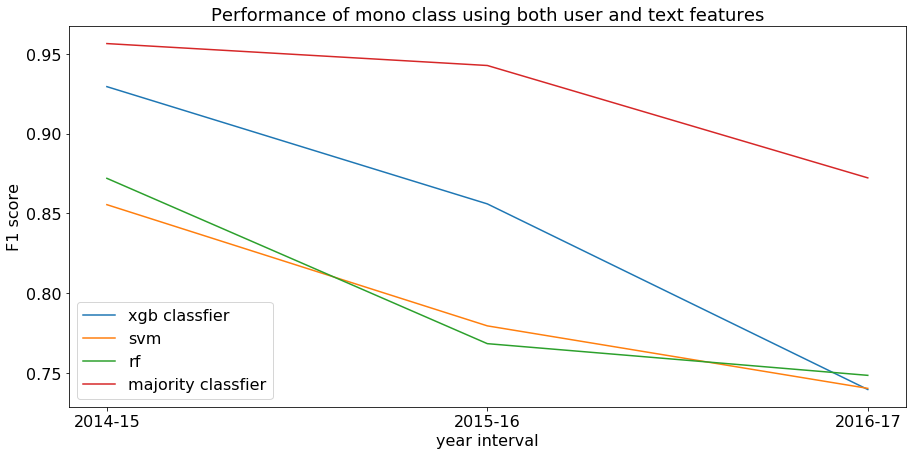

In [71]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_mono = [score for score in maj_mono]
for scores in final_scores:
    svm_scores.append(scores["svm"][0])
    rf_scores.append(scores["rf"][0])
    xgb_scores.append(scores["xgb"][0])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_mono,label="majority classfier")
plt.title("Performance of mono class using both user and text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

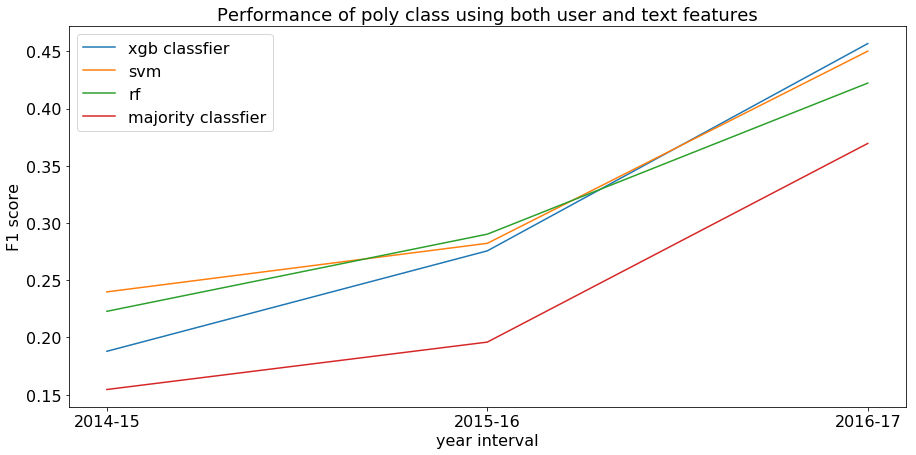

In [72]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_poly = [score for score in maj_poly]
for scores in final_scores:
    svm_scores.append(scores["svm"][1])
    rf_scores.append(scores["rf"][1])
    xgb_scores.append(scores["xgb"][1])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_poly,label="majority classfier")
plt.title("Performance of poly class using both user and text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [75]:
poly_scores =  { "svm" : svm_scores,
           "rf" : rf_scores,
           "xgb" : xgb_scores,
}
print(poly_scores)

{'svm': [0.2397734141996437, 0.28220597148961035, 0.45012865403771213], 'rf': [0.22279391007780242, 0.2902066380649208, 0.4222217254754927], 'xgb': [0.18785370887764605, 0.27562165995001314, 0.45674065579971845]}


In [79]:
for model, score in poly_scores.items():
    print(model,np.mean(score))

svm 0.32403601324232206
rf 0.31174075787273864
xgb 0.30673867487579254


In [77]:
import pickle

with open(os.path.join(model_dir,"user_text_oversample.pkl"),"wb") as f:
    pickle.dump(final_scores,f)

In [78]:
final_scores

[{'svm': array([0.85543324, 0.23977341]),
  'rf': array([0.87193173, 0.22279391]),
  'xgb': array([0.92934864, 0.18785371])},
 {'svm': array([0.77953105, 0.28220597]),
  'rf': array([0.76838755, 0.29020664]),
  'xgb': array([0.85591966, 0.27562166])},
 {'svm': array([0.74038666, 0.45012865]),
  'rf': array([0.7485409 , 0.42222173]),
  'xgb': array([0.73967439, 0.45674066])}]

### predicting features of the model

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
final_models = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    

    _,final_data = preprocessing.prepare_user_features(total_data)
    
    ## adding text to final data
    final_data["Text"] = total_data["tweetText"]
    
    ## train-test split
    train_data,test_data,Y_train,Y_test = train_test_split(final_data, Y, test_size=0.20, 
                                                     random_state=4,shuffle=True, stratify=Y)
    
    
    ## preapre text features
    X_train_svd,tf_idf, svd = encode_text_svd(train_data["Text"])
    X_test_svd = get_encoded_text_svd(test_data["Text"], tf_idf, svd)

    ## prepare user features
    X_train_text = train_data.loc[:, train_data.columns  !="Text"]
    X_test_text = test_data.loc[:, test_data.columns != "Text"]

    ## combine both of the features
    X_train = np.hstack((X_train_svd,X_train_text))  ## first text and then user features
    X_test = np.hstack((X_test_svd,X_test_text))
    
    ## oversampling
    X_train,Y_train = util.get_oversample(X_train,Y_train)
    ml_models = {"svm":[],"rf":[],"xgb":[]}
    
    ml_models = {}
    models = get_baseline_models()
    for name,model in models.items(): 
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print(name,"user Classification report \n",classification_report(y_pred,Y_test))
        ml_models[name] = model 
    final_models.append(ml_models)

100%|██████████| 1140/1140 [00:00<00:00, 2427.45it/s]


train-test split
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.72      0.93      0.81       162
          1       0.42      0.12      0.19        66

avg / total       0.64      0.70      0.63       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.77      0.94      0.85       172
          1       0.42      0.14      0.21        56

avg / total       0.68      0.74      0.69       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.94      0.92      0.93       213
          1       0.11      0.13      0.12        15

avg / total       0.88      0.87      0.88       228



100%|██████████| 2861/2861 [00:01<00:00, 1902.00it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.94      0.79       371
          1       0.63      0.20      0.30       202

avg / total       0.67      0.68      0.62       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.94      0.78       366
          1       0.63      0.19      0.30       207

avg / total       0.66      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.77      0.91      0.83       433
          1       0.37      0.16      0.23       140

avg / total       0.67      0.73      0.69       573



100%|██████████| 41902/41902 [00:15<00:00, 2681.34it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.86      0.75      4983
          1       0.64      0.36      0.46      3398

avg / total       0.65      0.66      0.63      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.70      0.83      0.76      5429
          1       0.53      0.34      0.41      2952

avg / total       0.64      0.66      0.64      8381

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.87      0.75      4928
          1       0.65      0.36      0.46      3453

avg / total       0.66      0.66      0.63      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


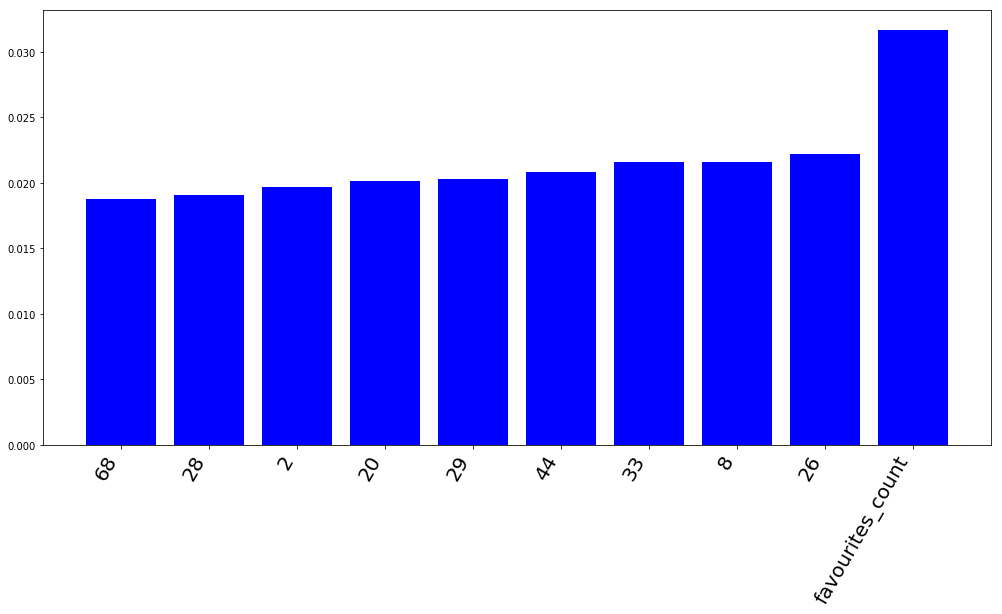

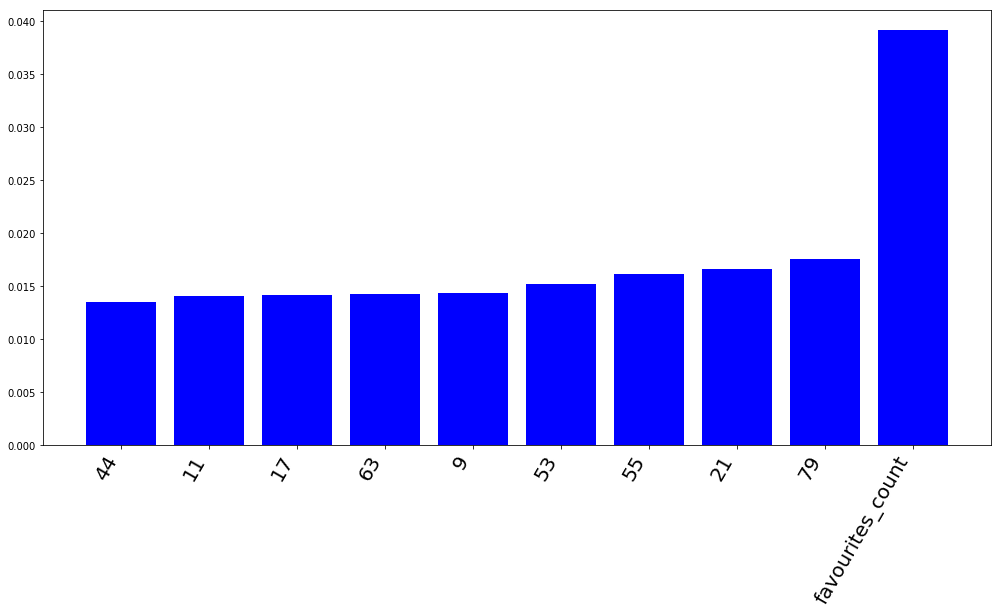

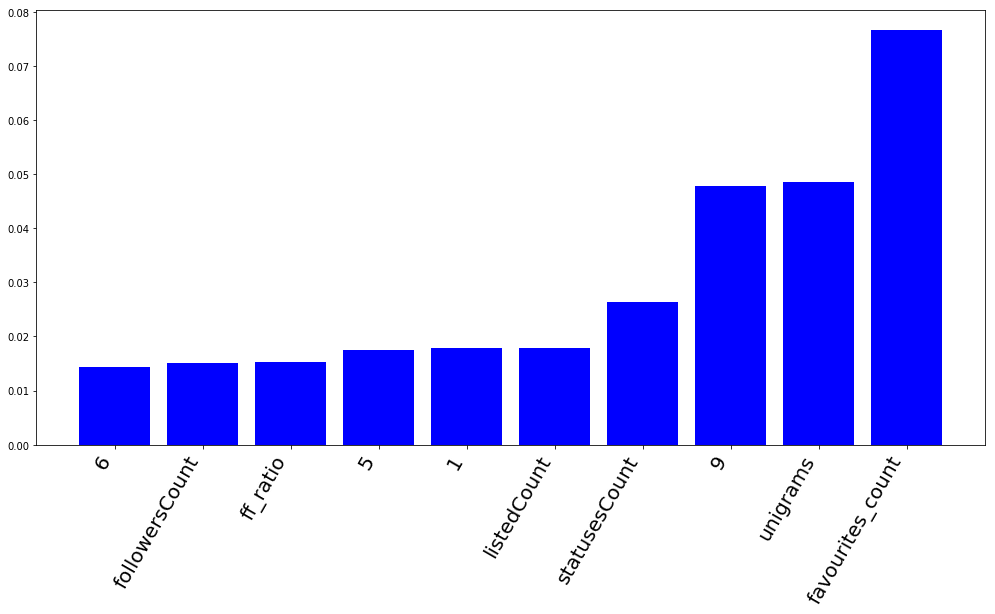

In [104]:
user_columns = list(final_data.loc[:, final_data.columns != "Text"].columns)
text_feat = [str(i) for i in range(100)]
columns = text_feat + user_columns

for model in final_models:
    xgb_ = model["xgb"]
    plot_model_coeff(xgb_,10,columns)

## capturing the text features

In [62]:
##  transform the data based on trained tfidf and svd
def get_encoded_text_svd(test_data, tf_idf, svd):
    X_test = tf_idf.transform(test_data)
    X_test = svd.transform(X_test)  ## reduce the dimensionality
    return X_test

In [37]:
## @ param : text data 
## @ return : svd transformed data
## vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
def encode_text_svd(data):
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    tf_idf.fit(data)  ## fit on train data
    temp_data = tf_idf.transform(data)
    svd.fit(temp_data)
    final_data = (svd.transform(temp_data))
    return (final_data,tf_idf, svd)
#     final_data = pd.DataFrame(text_data)

In [64]:
embedding_file = os.path.join(embeddings_dir, "glove.twitter.27B.100d.txt")
## prepare the tokenizer
# @return encoded data, max len , vocalb size and embeddign matrix
def prepare_lstm_data(data,dimension):
    max_len = util.get_max_length(data)
    if max_len > 60:
        max_len = 60
    print("max_length", max_len)
    keras_tkzr = lstm_module.fit_tokenizer(data)
    vocalb_size = len(keras_tkzr.word_index) + 1
    print("vocalb", vocalb_size)

    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = util.get_embedding_matrix(vocalb_size, dimension, util.embedding_file,
                                                 keras_tkzr)  ## tokenizer contains the vocalb info
    ## encoding the docs
    print("encoding the data")
    X = lstm_module.get_encoded_data(data, keras_tkzr, max_len)

    print("X-train", X.shape)
    
    return (X,keras_tkzr,max_len,vocalb_size,embedding_matrix)

100%|██████████| 911/911 [00:00<00:00, 230153.65it/s]


train-test split
final_data (1140, 1) Y 1140
at split 0
max_length 38
preparing the tokenizer
vocalb 3617
creating glove embeddign matrix
encoding the data
X-train (911, 38)
y 1668   1668
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 38)                0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 38, 100)           361700    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 402       
Total params: 522,902
Trainable params: 522,902
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
            

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.94      0.92      0.93       213
          1       0.15      0.19      0.17        16

avg / total       0.88      0.87      0.88       229

Train on 1251 samples, validate on 417 samples
Epoch 1/20
1251/1251 [==============================] - 10s 8ms/step - loss: 1.6009 - acc: 0.6579 - val_loss: 1.5049 - val_acc: 0.0695
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.8258 - acc: 0.6962 - val_loss: 1.0494 - val_acc: 0.3333
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.5274 - acc: 0.7794 - val_loss: 0.6602 - val_acc: 0.6906
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3948 - acc: 0.8337 - val_loss: 0.5084 - val_acc: 0.7962
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.2987 - acc: 0.8817 - val_loss: 0.3000 - val_acc: 0.8897
Epoch 6/20
1251/1251 [============

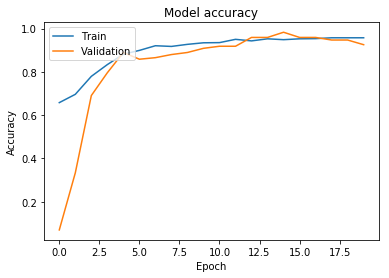

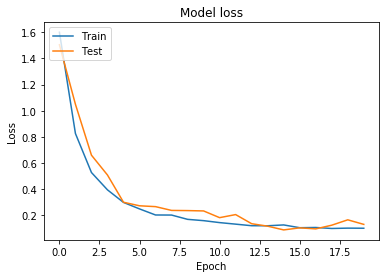

100%|██████████| 911/911 [00:00<00:00, 241515.13it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.95      0.93       209
          1       0.21      0.15      0.18        20

avg / total       0.86      0.88      0.87       229
 

at split 1
max_length 38
preparing the tokenizer
vocalb 3597
creating glove embeddign matrix


encoding the data
X-train (911, 38)
y 1668   1668
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 38)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 38, 100)           359700    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 402       
Total params: 520,902
Trainable params: 520,902
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.72      0.94      0.81       160
          1       0.50      0.14      0.22

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       211
          1       0.20      0.22      0.21        18

avg / total       0.88      0.87      0.87       229

Train on 1251 samples, validate on 417 samples
Epoch 1/20
1251/1251 [==============================] - 10s 8ms/step - loss: 1.5989 - acc: 0.6619 - val_loss: 1.3385 - val_acc: 0.3861
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.8326 - acc: 0.7002 - val_loss: 0.9863 - val_acc: 0.4173
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.5358 - acc: 0.7818 - val_loss: 0.5929 - val_acc: 0.7290
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3813 - acc: 0.8489 - val_loss: 0.4085 - val_acc: 0.7962
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3096 - acc: 0.8713 - val_loss: 0.2673 - val_acc: 0.8849
Epoch 6/20
1251/1251 [============

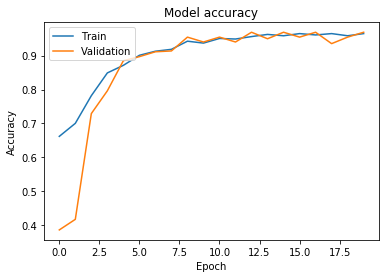

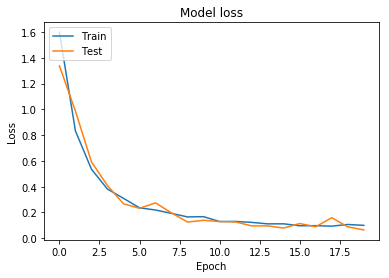

100%|██████████| 912/912 [00:00<00:00, 165128.65it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.91      0.92       209
          1       0.18      0.20      0.19        20

avg / total       0.86      0.85      0.85       229
 

at split 2
max_length 38
preparing the tokenizer
vocalb 3614
creating glove embeddign matrix


encoding the data
X-train (912, 38)
y 1668   1668
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 38)                0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 38, 100)           361400    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 402       
Total params: 522,602
Trainable params: 522,602
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.90      0.85       187
          1       0.05      0.02      0.03

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.95      0.91      0.93       217
          1       0.00      0.00      0.00        11

avg / total       0.90      0.87      0.88       228

Train on 1251 samples, validate on 417 samples
Epoch 1/20
1251/1251 [==============================] - 11s 9ms/step - loss: 1.6045 - acc: 0.6523 - val_loss: 1.3638 - val_acc: 0.0504
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.8300 - acc: 0.6994 - val_loss: 1.0474 - val_acc: 0.4436
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.5228 - acc: 0.7978 - val_loss: 0.8436 - val_acc: 0.6235
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3921 - acc: 0.8497 - val_loss: 0.3633 - val_acc: 0.9137
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3123 - acc: 0.8729 - val_loss: 0.2388 - val_acc: 0.9257
Epoch 6/20
1251/1251 [============

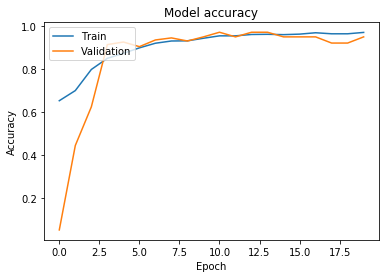

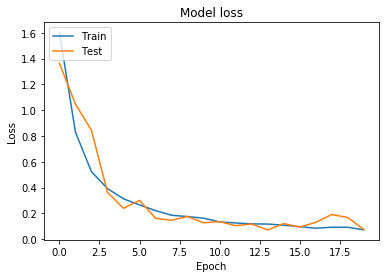

100%|██████████| 913/913 [00:00<00:00, 217480.67it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.94      0.93       209
          1       0.14      0.11      0.12        19

avg / total       0.86      0.87      0.86       228
 

at split 3
max_length 44
preparing the tokenizer
vocalb 3784
creating glove embeddign matrix


encoding the data
X-train (913, 44)
y 1670   1670
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 44)                0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 44, 100)           378400    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 402       
Total params: 539,602
Trainable params: 539,602
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.79      0.93      0.85       178
          1       0.32      0.12      0.18

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.88      0.92      0.90       200
          1       0.16      0.11      0.13        27

avg / total       0.80      0.82      0.81       227

Train on 1252 samples, validate on 418 samples
Epoch 1/20
1252/1252 [==============================] - 12s 9ms/step - loss: 1.6041 - acc: 0.6446 - val_loss: 1.5327 - val_acc: 0.0000e+00
Epoch 2/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.8175 - acc: 0.7021 - val_loss: 0.9845 - val_acc: 0.4713
Epoch 3/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.5197 - acc: 0.8003 - val_loss: 0.6283 - val_acc: 0.7656
Epoch 4/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3984 - acc: 0.8315 - val_loss: 0.3032 - val_acc: 0.9043
Epoch 5/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3058 - acc: 0.8810 - val_loss: 0.2377 - val_acc: 0.9211
Epoch 6/20
1252/1252 [========

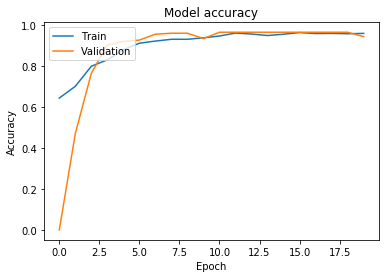

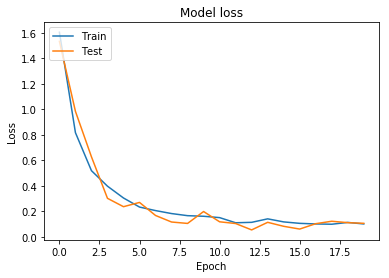

100%|██████████| 913/913 [00:00<00:00, 235120.01it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.94      0.93       208
          1       0.20      0.16      0.18        19

avg / total       0.86      0.88      0.87       227
 

at split 4
max_length 39
preparing the tokenizer
vocalb 3631
creating glove embeddign matrix


encoding the data
X-train (913, 39)
y 1670   1670
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 39)                0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 39, 100)           363100    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 402       
Total params: 524,302
Trainable params: 524,302
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.92      0.86       184
          1       0.21      0.09      0.13

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.91      0.92      0.92       207
          1       0.11      0.10      0.10        20

avg / total       0.84      0.85      0.84       227

Train on 1252 samples, validate on 418 samples
Epoch 1/20
1252/1252 [==============================] - 11s 9ms/step - loss: 1.6106 - acc: 0.6605 - val_loss: 1.4369 - val_acc: 0.1699
Epoch 2/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.8407 - acc: 0.7021 - val_loss: 1.0911 - val_acc: 0.3708
Epoch 3/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.5406 - acc: 0.7931 - val_loss: 0.6659 - val_acc: 0.7273
Epoch 4/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3883 - acc: 0.8395 - val_loss: 0.3938 - val_acc: 0.8517
Epoch 5/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3146 - acc: 0.8722 - val_loss: 0.2907 - val_acc: 0.8995
Epoch 6/20
1252/1252 [============

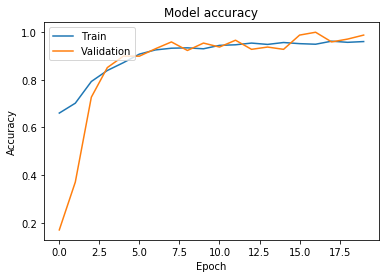

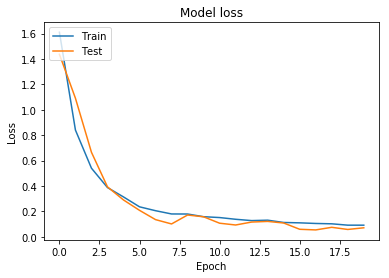

  0%|          | 0/2861 [00:00<?, ?it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.91      0.90      0.91       208
          1       0.05      0.05      0.05        19

avg / total       0.84      0.83      0.84       227
 

svm [0.84860914 0.14853195]
rf [0.84479998 0.1353039 ]
xgb [0.92093646 0.12203837]
lstm [0.92504389 0.1429259 ]


100%|██████████| 2288/2288 [00:00<00:00, 210566.48it/s]


train-test split
final_data (2861, 1) Y 2861
at split 0
max_length 40
preparing the tokenizer
vocalb 7134
creating glove embeddign matrix
encoding the data
X-train (2288, 40)
y 4076   4076
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 40, 100)           713400    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 402       
Total params: 874,602
Trainable params: 874,602
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
           

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.83      0.89      0.86       472
          1       0.21      0.13      0.16       101

avg / total       0.72      0.76      0.74       573

Train on 3057 samples, validate on 1019 samples
Epoch 1/20
3057/3057 [==============================] - 17s 6ms/step - loss: 1.1427 - acc: 0.6627 - val_loss: 1.0498 - val_acc: 0.1079
Epoch 2/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.5780 - acc: 0.7053 - val_loss: 0.8406 - val_acc: 0.4907
Epoch 3/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.4784 - acc: 0.7697 - val_loss: 0.6653 - val_acc: 0.6006
Epoch 4/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.3872 - acc: 0.8247 - val_loss: 0.5569 - val_acc: 0.6948
Epoch 5/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.3025 - acc: 0.8724 - val_loss: 0.3898 - val_acc: 0.8479
Epoch 6/20
3057/3057 [=======

In [ ]:
## check with lstm

## preparing the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 20
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
        
    ## combining all of user and text data
    final_data = pd.DataFrame()
    final_data["Text"] = pd.DataFrame(total_data["tweetText"])
    print("final_data",final_data.shape,"Y",len(Y))
    
    
    fold_scores = {"svm":[],"rf":[],"xgb":[],"lstm":[]}
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y)):
        print("at split",split)
        Y_test =  Y[test_ind]
        Y_train = Y[train_ind]
        
        test_data = final_data.iloc[test_ind]
        train_data = final_data.iloc[train_ind]
        
        ## preparing train,test lstm
        X_train_lstm,keras_tkzr,max_len,vocalb_size,embedding_matrix = prepare_lstm_data(train_data["Text"],dimension)
        X_test_lstm = lstm_module.get_encoded_data(test_data["Text"],keras_tkzr,max_len)
        
        ## preparing train,test tf_idf svd
        X_train_svd,tf_idf, svd = encode_text_svd(train_data["Text"])
        X_test_svd = get_encoded_text_svd(test_data["Text"], tf_idf, svd)
        
        ## oversample the train data
        X_train_svd, Y_train_ = util.get_oversample(X_train_svd,Y_train)
        X_train_lstm, Y_train = util.get_oversample(X_train_lstm,Y_train)
        
        print("y",len(Y_train)," ",len(Y_train_))
        
        ## preparing the models
        models = get_baseline_models()
        lstm_model = lstm_module.create_model(max_len,vocalb_size,100,embedding_matrix)
        for name,model in models.items(): 
            model.fit(X_train_svd,Y_train)
            y_pred = model.predict(X_test_svd)
            print(name,"user Classification report \n",classification_report(y_pred,Y_test))
            score = (precision_recall_fscore_support(y_pred, Y_test, average=None)[2])
            fold_scores[name].append(score)
        
        ## getting lstm prediction
        history = lstm_model.fit(X_train_lstm,Y_train,validation_split=0.25, nb_epoch=epoch,verbose=1, batch_size=32)
        lstm_module.training_plot(history) ## plotting the training history lstm
        lstm_pred_ = lstm_model.predict(X_test_lstm)
        lstm_pred = [np.argmax(value) for value in lstm_pred_]  ## sigmoid
        print('  Classification Report lstm:\n', classification_report(Y_test, lstm_pred), '\n')
        score = (precision_recall_fscore_support(Y_test, lstm_pred, average=None)[2])
        fold_scores["lstm"].append(score)
    
    for name,scores in fold_scores.items():
        score1 = np.mean([ele[0] for ele in scores])
        score2 = np.mean([ele[1] for ele in scores])
        fold_scores[name] = np.array([score1,score2])
        print(name,fold_scores[name])
    final_scores.append(fold_scores)
    Y_tests.append(Y_test)

In [29]:
import pickle

with open(os.path.join(model_dir,"text_oversample.pkl"),"wb") as f:
    pickle.dump(final_scores,f)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## plot the text features

In [41]:
final_scores = pickle.load(open(os.path.join(model_dir,"text_oversample.pkl"),"rb"))

In [47]:
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    Y_tests.append(Y_test)

  0%|          | 0/2861 [00:00<?, ?it/s]

train-test split


100%|██████████| 2861/2861 [00:00<00:00, 3108.09it/s]


train-test split


100%|██████████| 41902/41902 [00:09<00:00, 4552.74it/s]


train-test split


In [48]:
from sklearn.metrics import precision_recall_fscore_support
maj_mono = []
maj_poly = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos)[2][1]
    maj_poly.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg)[2][0]
    maj_mono.append(maj_neg)

length of Y_test 228
positives in Y_test 19
length of Y_test 573
positives in Y_test 63
length of Y_test 8381
positives in Y_test 1900


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


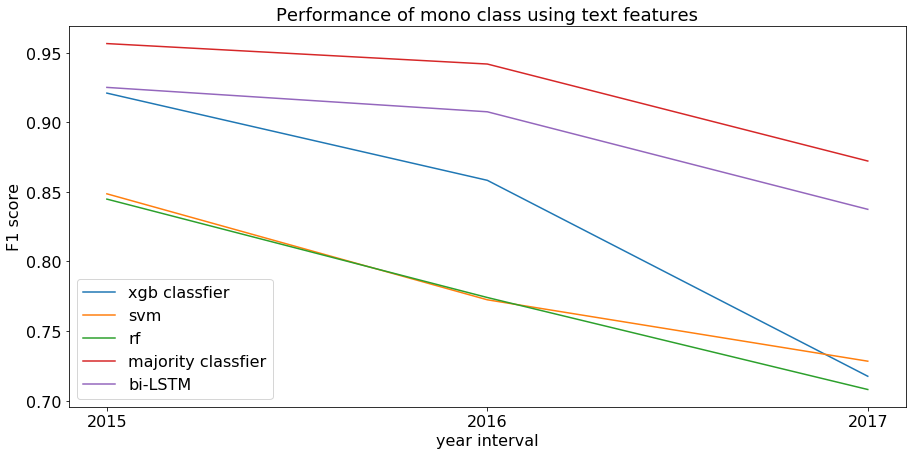

In [49]:
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores= []
all_mono = [score for score in maj_mono]
for scores in final_scores:
    svm_scores.append(scores["svm"][0])
    rf_scores.append(scores["rf"][0])
    xgb_scores.append(scores["xgb"][0])
    lstm_scores.append(scores["lstm"][0])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_mono,label="majority classfier")
plt.plot(years,lstm_scores,label="bi-LSTM")
plt.title("Performance of mono class using text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

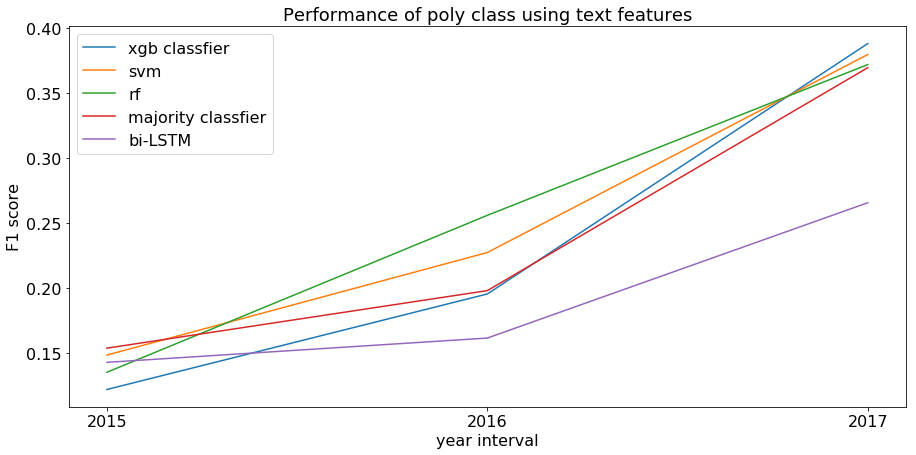

In [50]:
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores= []
all_poly = [score for score in maj_poly]
for scores in final_scores:
    svm_scores.append(scores["svm"][1])
    rf_scores.append(scores["rf"][1])
    xgb_scores.append(scores["xgb"][1])
    lstm_scores.append(scores["lstm"][1])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_poly,label="majority classfier")
plt.plot(years,lstm_scores,label="bi-LSTM")
plt.title("Performance of poly class using text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## relevance of text features

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
final_models = []
vectorizer = []
for year,data,users_labelled in bucket_data[:2]:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    train_data,test_data,Y_train,Y_test = train_test_split(total_data, Y, test_size=0.20, 
                                                     random_state=4,shuffle=True, stratify=Y)
    
    ## preparing train,test tf_idf svd
    X_train,tf_idf, svd = encode_text_svd(train_data["tweetText"])
    X_test = get_encoded_text_svd(test_data["tweetText"], tf_idf, svd)

    ## oversample the train data
    X_train, Y_train = util.get_oversample(X_train,Y_train)
    
    ml_models = {"svm":[],"rf":[],"xgb":[]}
    
    models = get_baseline_models()
    for name,model in models.items(): 
        model.fit(X_train,Y_train)
        ml_models[name] = model 
    vectorizer.append(tf_idf)
    final_models.append(ml_models)

100%|██████████| 1140/1140 [00:00<00:00, 3025.26it/s]


train-test split
[LibLinear]

100%|██████████| 2861/2861 [00:00<00:00, 2999.43it/s]


train-test split
[LibLinear]

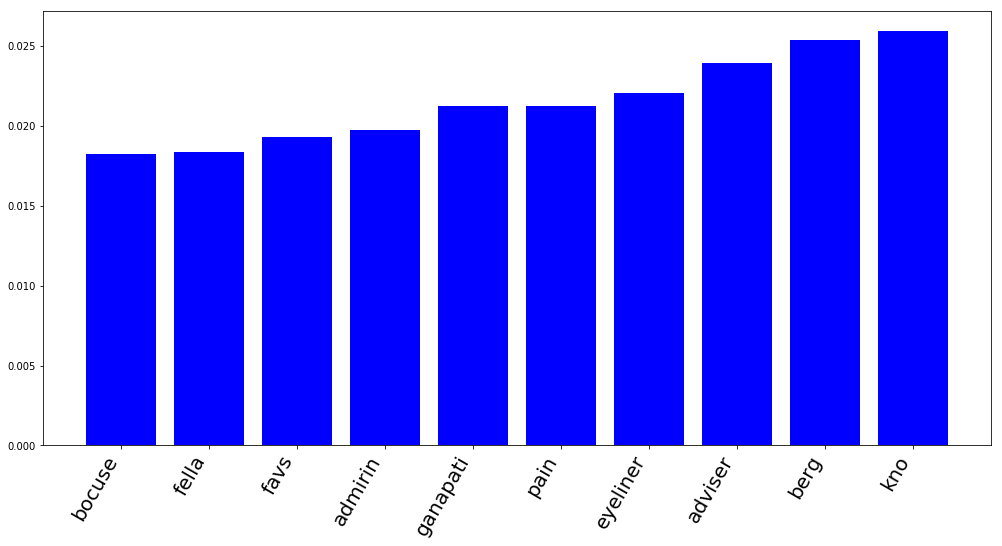

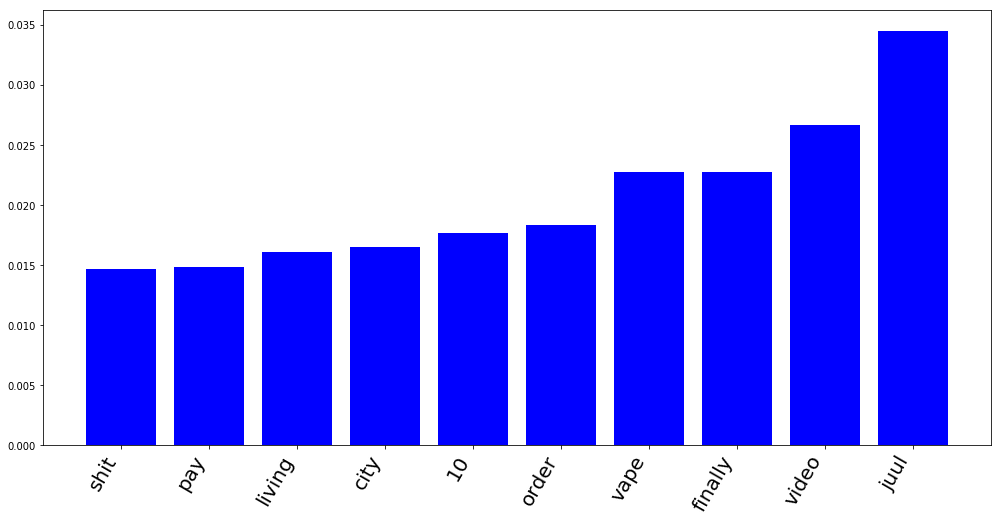

In [395]:
for model,tf_idf in zip(final_models,vectorizer):
    xgb_ = model["rf"]
    plot_model_coeff(xgb_,10,list(tf_idf.get_feature_names()))

## predicting with the user features

In [229]:
# Algorithm
# Split the train set in k folds
# Fit a first stage model on k-1 folds and predict the kth fold
# Repeat 2) to predict each fold

## preparing the data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    # vectorize the text
#     tf_idf.fit(total_data["tweetText"])  ## fit on train data
#     temp_data = tf_idf.transform(total_data["tweetText"])
#     svd.fit(temp_data)
#     text_data = (svd.transform(temp_data))
    
    _,final_data = preprocessing.prepare_user_features(total_data)
    
#     print("text_data",text_data.shape,"Y",len(Y_text))
    print("final_data",final_data.shape,"Y",len(Y))
    
    ## combining all of user and text data
#     final_data = pd.DataFrame(text_data)
#     final_data = pd.concat([text_data.reset_index(drop=True), user_data.reset_index(drop=True)], axis= 1)
    Y_final = Y
    
    
    fold_scores = {"svm":[],"rf":[],"xgb":[]}
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y_final)):
        print("at split",split)
        X_test = final_data.iloc[test_ind].values
        Y_test =  Y_final[test_ind]
        
        Y_train = Y_final[train_ind]
        X_train = final_data.iloc[train_ind].values
        X_train, Y_train = util.get_oversample(X_train,Y_train)
        
        models = get_baseline_models()
        for name,model in models.items(): 
            model.fit(X_train,Y_train)
            y_pred = model.predict(X_test)
            print(name,"user Classification report \n",classification_report(y_pred,Y_test))
            score = (precision_recall_fscore_support(Y_test, y_pred, average=None)[2])
            fold_scores[name].append(score)
        ## getting lstm prediction
    for name,scores in fold_scores.items():
        score1 = np.mean([ele[0] for ele in scores])
        score2 = np.mean([ele[1] for ele in scores])
        fold_scores[name] = np.array([score1,score2])
        print(name,fold_scores[name])
    final_scores.append(fold_scores)
    Y_tests.append(Y_test)

100%|██████████| 1140/1140 [00:00<00:00, 4094.28it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

final_data (1140, 7) Y 1140
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.95      0.77       141
          1       0.65      0.15      0.24        88

avg / total       0.64      0.64      0.56       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.93      0.74       137
          1       0.55      0.12      0.20        92

avg / total       0.59      0.61      0.52       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.85      0.92      0.88       194
          1       0.20      0.11      0.15        35

avg / total       0.75      0.79      0.77       229

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.94      0.72       130
          1       0.60      0.12      0.20        99

avg / total       0.59      0.59      0.50       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.94      0.71       128
          1       0.60      0.12      0.20       101

avg / total       0.59      0.58      0.49       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.93      0.87       181
          1       0.40      0.17      0.24        48

avg / total       0.72      0.77      0.73       229

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.93      0.73       135
          1       0.53      0.11      0.18        93

avg / total       0.57      0.60      0.51       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.96      0.79       146
          1       0.68      0.16      0.26        82

avg / total       0.68      0.67      0.60       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.85      0.94      0.89       189
          1       0.37      0.18      0.24        39

avg / total       0.77      0.81      0.78       228

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.95      0.77       142
          1       0.63      0.14      0.23        85

avg / total       0.64      0.65      0.57       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.96      0.78       142
          1       0.68      0.15      0.25        85

avg / total       0.67      0.66      0.58       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.91      0.87       187
          1       0.16      0.07      0.10        40

avg / total       0.71      0.77      0.73       227

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.53      0.97      0.69       115
          1       0.79      0.13      0.23       112

avg / total       0.66      0.56      0.46       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.97      0.74       128
          1       0.79      0.15      0.25        99

avg / total       0.68      0.61      0.53       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
  0%|          | 0/2861 [00:00<?, ?it/s]

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.92      0.86       183
          1       0.26      0.11      0.16        44

avg / total       0.71      0.77      0.73       227

svm [0.7353543  0.21615394]
rf [0.75120421 0.23128774]
xgb [0.8739523  0.17651061]


100%|██████████| 2861/2861 [00:00<00:00, 3244.62it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

final_data (2861, 7) Y 2861
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.97      0.70       287
          1       0.86      0.19      0.31       286

avg / total       0.70      0.58      0.50       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.95      0.74       324
          1       0.75      0.19      0.30       249

avg / total       0.67      0.62      0.55       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.95      0.78       358
          1       0.70      0.20      0.32       215

avg / total       0.68      0.67      0.61       573

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.95      0.72       309
          1       0.78      0.19      0.30       264

avg / total       0.67      0.60      0.53       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.95      0.69       293
          1       0.76      0.17      0.28       280

avg / total       0.65      0.57      0.49       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.93      0.79       377
          1       0.59      0.19      0.29       196

avg / total       0.65      0.68      0.62       573

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.97      0.72       298
          1       0.87      0.20      0.33       275

avg / total       0.71      0.60      0.53       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.54      0.96      0.69       286
          1       0.83      0.18      0.30       287

avg / total       0.68      0.57      0.49       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.94      0.80       373
          1       0.67      0.21      0.32       200

avg / total       0.68      0.69      0.63       573

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.95      0.70       294
          1       0.77      0.17      0.28       277

avg / total       0.66      0.57      0.50       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.56      0.94      0.70       302
          1       0.69      0.16      0.26       269

avg / total       0.62      0.57      0.49       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.94      0.80       374
          1       0.65      0.20      0.31       197

avg / total       0.68      0.69      0.63       571

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.51      0.96      0.66       270
          1       0.81      0.17      0.28       301

avg / total       0.66      0.54      0.46       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.52      0.96      0.67       277
          1       0.81      0.17      0.28       294

avg / total       0.67      0.55      0.47       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.94      0.76       348
          1       0.66      0.18      0.29       223

avg / total       0.65      0.64      0.58       571

svm [0.69912021 0.2986523 ]
rf [0.69883429 0.28380518]
xgb [0.78604579 0.30365046]


100%|██████████| 41902/41902 [00:09<00:00, 4626.73it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

final_data (41902, 7) Y 41902
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.87      0.72      4577
          1       0.68      0.34      0.45      3804

avg / total       0.64      0.63      0.60      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4100
          1       0.71      0.31      0.44      4281

avg / total       0.63      0.58      0.55      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.87      0.73      4615
          1       0.69      0.35      0.46      3766

avg / total       0.65      0.64      0.61      8381

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.71      4624
          1       0.66      0.33      0.44      3757

avg / total       0.63      0.62      0.59      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4150
          1       0.68      0.31      0.42      4231

avg / total       0.62      0.58      0.55      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4712
          1       0.65      0.34      0.44      3669

avg / total       0.64      0.63      0.60      8381

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4664
          1       0.65      0.33      0.44      3716

avg / total       0.63      0.63      0.60      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.86      0.69      4356
          1       0.67      0.32      0.43      4024

avg / total       0.62      0.60      0.57      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.63      0.86      0.73      4783
          1       0.64      0.34      0.44      3597

avg / total       0.63      0.63      0.60      8380

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.72      4608
          1       0.66      0.33      0.44      3772

avg / total       0.64      0.62      0.59      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4113
          1       0.70      0.31      0.43      4267

avg / total       0.62      0.58      0.55      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4660
          1       0.66      0.34      0.45      3720

avg / total       0.64      0.63      0.60      8380

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.71      4611
          1       0.65      0.33      0.43      3769

avg / total       0.63      0.62      0.59      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.52      0.87      0.65      3908
          1       0.73      0.31      0.43      4472

avg / total       0.63      0.57      0.54      8380

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.87      0.72      4647
          1       0.67      0.34      0.45      3733

avg / total       0.64      0.63      0.6

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [231]:
with open(os.path.join(model_dir,"user_oversample.pkl"),"wb") as f:
    pickle.dump(final_scores,f)

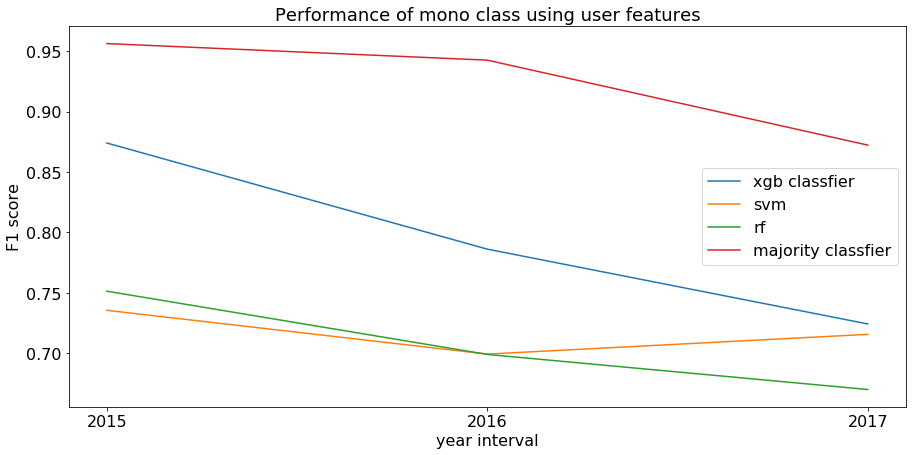

In [40]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_mono = [score for score in maj_mono]
for scores in final_scores:
    svm_scores.append(scores["svm"][0])
    rf_scores.append(scores["rf"][0])
    xgb_scores.append(scores["xgb"][0])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_mono,label="majority classfier")
plt.title("Performance of mono class using user features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

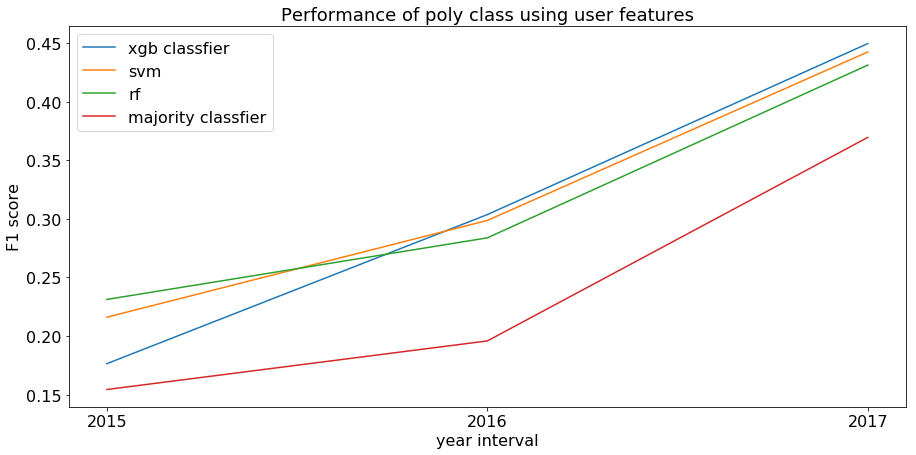

In [41]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_poly = [score for score in maj_poly]
for scores in final_scores:
    svm_scores.append(scores["svm"][1])
    rf_scores.append(scores["rf"][1])
    xgb_scores.append(scores["xgb"][1])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_poly,label="majority classfier")
plt.title("Performance of poly class using user features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [46]:
poly_scores =  { "svm" : svm_scores,
           "rf" : rf_scores,
           "xgb" : xgb_scores,
}
print(poly_scores)

{'svm': [0.21615394118761877, 0.2986522996698243, 0.44236961584393847], 'rf': [0.23128774191528773, 0.2838051795742852, 0.43115868775006555], 'xgb': [0.17651060948616557, 0.30365045808222507, 0.4495033095077442]}


In [47]:
for model, score in poly_scores.items():
    print(model,np.mean(score))

svm 0.3190586189004605
rf 0.31541720307987947
xgb 0.30988812569204494


In [48]:
final_scores

[{'svm': array([0.7353543 , 0.21615394]),
  'rf': array([0.75120421, 0.23128774]),
  'xgb': array([0.8739523 , 0.17651061])},
 {'svm': array([0.69912021, 0.2986523 ]),
  'rf': array([0.69883429, 0.28380518]),
  'xgb': array([0.78604579, 0.30365046])},
 {'svm': array([0.71545435, 0.44236962]),
  'rf': array([0.66977735, 0.43115869]),
  'xgb': array([0.72408211, 0.44950331])}]

## relevance of user features

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
final_models = []
vectorizer = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    _,user_data = preprocessing.prepare_user_features(total_data)
        
    ## combining all of user and text data
    X = user_data.values
    
    X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.20, 
                                                     random_state=4,shuffle=True, stratify=Y)
    
    X_train,Y_train = util.get_oversample(X_train,Y_train)
    ml_models = {"svm":[],"rf":[],"xgb":[]}
    
    ml_models = {}
    models = get_baseline_models()
    for name,model in models.items(): 
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print(name,"user Classification report \n",classification_report(y_pred,Y_test))
        ml_models[name] = model 
    final_models.append(ml_models)

100%|██████████| 1140/1140 [00:00<00:00, 2462.59it/s]


train-test split
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.95      0.72       127
          1       0.68      0.13      0.22       101

avg / total       0.63      0.59      0.50       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.95      0.74       133
          1       0.63      0.13      0.21        95

avg / total       0.61      0.61      0.52       228

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.94      0.87       178
          1       0.47      0.18      0.26        50

avg / total       0.73      0.78      0.74       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
100%|██████████| 2861/2861 [00:01<00:00, 1952.18it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.54      0.98      0.70       283
          1       0.89      0.19      0.32       290

avg / total       0.72      0.58      0.50       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.54      0.96      0.69       285
          1       0.81      0.18      0.29       288

avg / total       0.67      0.57      0.49       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.94      0.78       363
          1       0.65      0.20      0.30       210

avg / total       0.66      0.67      0.60       573



100%|██████████| 41902/41902 [00:14<00:00, 2807.81it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4673
          1       0.66      0.34      0.44      3708

avg / total       0.64      0.63      0.60      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.86      0.68      4308
          1       0.67      0.31      0.43      4073

avg / total       0.62      0.59      0.56      8381

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.63      0.86      0.73      4761
          1       0.65      0.34      0.45      3620

avg / total       0.64      0.64      0.61      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


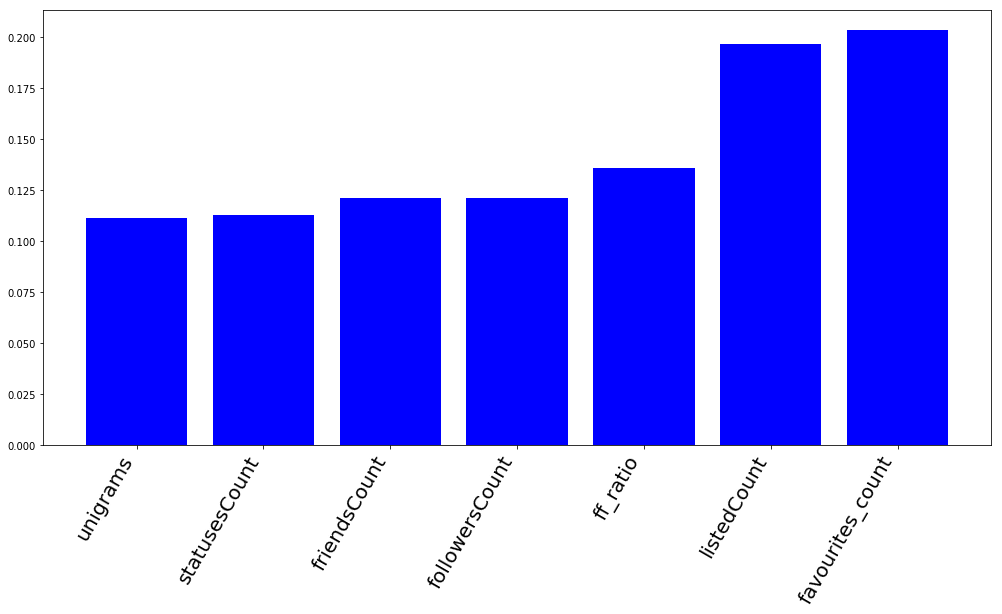

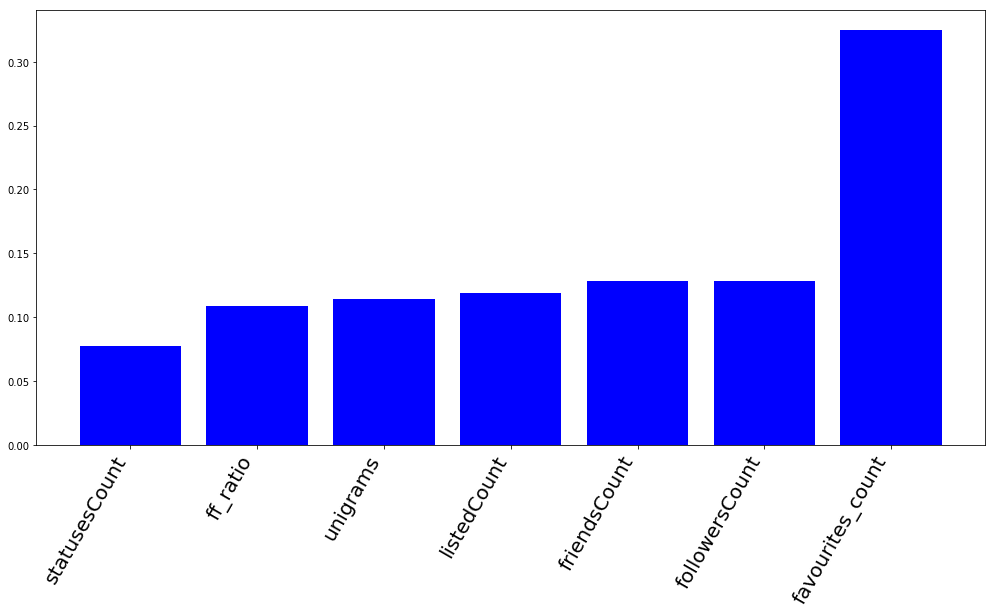

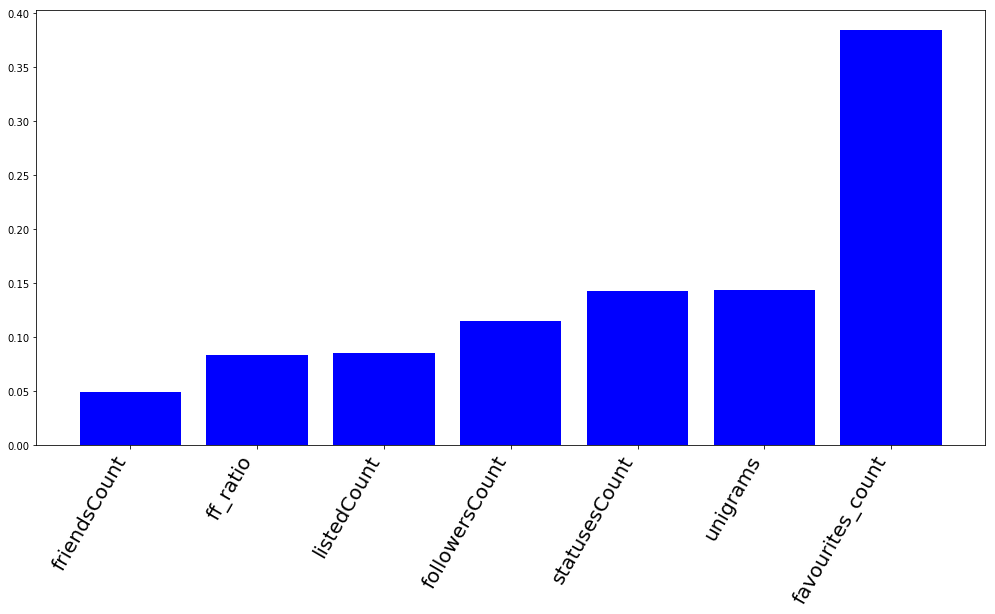

In [51]:
for model in (final_models):
    xgb_ = model["xgb"]
    plot_model_coeff(xgb_,7,list(user_data.columns))

## using the ensemble way

In [41]:
# Algorithm
# Split the train set in k folds
# Fit a first stage model on k-1 folds and predict the kth fold
# Repeat 2) to predict each fold

## preparing the data, taking 6 classfiers without lstm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    _,final_data = preprocessing.prepare_user_features(total_data)
    
    final_data["Text"] = total_data["tweetText"]
    Y_final = Y
    
    df_pred_temp = pd.DataFrame()
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y_final)):
        print("at split",split)
        Y_test =  Y_final[test_ind]
        Y_train = Y_final[train_ind]
        
        test_data = final_data.iloc[test_ind]
        train_data = final_data.iloc[train_ind]
        
        text_columns = ["Text"]
        
        ## preapre text features
        X_train_text,tf_idf, svd = encode_text_svd(train_data["Text"])
        X_test_text = baselines.get_encoded_text_svd(test_data["Text"], tf_idf, svd)
        
        ### prepare user features
        X_train_user = train_data.drop(text_columns,axis=1).values
        X_test_user = test_data.drop(text_columns,axis=1).values
        
        ## combine both of the features
        X_train = np.hstack((X_train_text,X_train_user))
        X_train, Y_train = util.get_oversample(X_train,Y_train)   ## oversample
        X_test = np.hstack((X_test_text,X_test_user))
       
        models = baselines.get_baseline_models()
        df_pred = {}
        for name,model in models.items(): 
            model.fit(X_train,Y_train)
            pred = model.predict(X_test)
            df_pred[name]  = list(pred) 
            print(name,"Classification report \n",classification_report(pred,Y_test))
            
        df_pred["Y"] = list(Y_test)
        temp = pd.DataFrame.from_dict(df_pred,orient="columns")
        df_pred_temp = df_pred_temp.append(temp)
    df_pred_final.append(df_pred_temp)

100%|██████████| 1140/1140 [00:00<00:00, 4137.24it/s]


train-test split
at split 0
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.77      0.94      0.84       171
          1       0.45      0.16      0.23        58

avg / total       0.69      0.74      0.69       229

rf Classification report 
              precision    recall  f1-score   support

          0       0.80      0.94      0.86       178
          1       0.45      0.18      0.25        51

avg / total       0.72      0.77      0.73       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       211
          1       0.20      0.22      0.21        18

avg / total       0.88      0.87      0.87       229

at split 1
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.71      0.94      0.81       159
          1       0.50      0.14      0.22        70

avg / total       0.65      0.69      0.63       229

rf Classification report 
              precision    recall  f1-score   support

          0       0.80      0.93      0.86       180
          1       0.35      0.14      0.20        49

avg / total       0.70      0.76      0.72       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.93      0.93      0.93       208
          1       0.30      0.29      0.29        21

avg / total       0.87      0.87      0.87       229

at split 2
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.82      0.93      0.88       184
          1       0.37      0.16      0.22        44

avg / total       0.74      0.79      0.75       228

rf Classification report 
              precision    recall  f1-score   support

          0       0.87      0.92      0.89       196
          1       0.21      0.12      0.16        32

avg / total       0.77      0.81      0.79       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.96      0.92      0.94       217
          1       0.11      0.18      0.13        11

avg / total       0.92      0.89      0.90       228

at split 3
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.84      0.95      0.89       185
          1       0.47      0.21      0.30        42

avg / total       0.77      0.81      0.78       227

rf Classification report 
              precision    recall  f1-score   support

          0       0.79      0.95      0.86       172
          1       0.58      0.20      0.30        55

avg / total       0.74      0.77      0.73       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.92      0.93      0.92       205
          1       0.26      0.23      0.24        22

avg / total       0.85      0.86      0.86       227

at split 4
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.79      0.94      0.86       176
          1       0.42      0.16      0.23        51

avg / total       0.71      0.76      0.72       227

rf Classification report 
              precision    recall  f1-score   support

          0       0.84      0.93      0.88       187
          1       0.32      0.15      0.20        40

avg / total       0.74      0.79      0.76       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
  0%|          | 0/2861 [00:00<?, ?it/s]

xgb Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.92       212
          1       0.05      0.07      0.06        15

avg / total       0.87      0.86      0.87       227



100%|██████████| 2861/2861 [00:00<00:00, 3206.58it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.66      0.92      0.77       367
          1       0.51      0.16      0.24       206

avg / total       0.60      0.64      0.58       573

rf Classification report 
              precision    recall  f1-score   support

          0       0.68      0.94      0.79       368
          1       0.63      0.20      0.30       205

avg / total       0.66      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.82      0.91      0.86       458
          1       0.35      0.19      0.25       115

avg / total       0.72      0.77      0.74       573

at split 1
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.69      0.93      0.79       382
          1       0.56      0.18      0.28       191

avg / total       0.65      0.68      0.62       573

rf Classification report 
              precision    recall  f1-score   support

          0       0.67      0.93      0.78       368
          1       0.62      0.19      0.29       205

avg / total       0.65      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.82      0.93      0.87       454
          1       0.46      0.24      0.32       119

avg / total       0.75      0.78      0.76       573

at split 2
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.66      0.94      0.78       359
          1       0.65      0.19      0.30       214

avg / total       0.66      0.66      0.60       573

rf Classification report 
              precision    recall  f1-score   support

          0       0.64      0.95      0.76       343
          1       0.71      0.20      0.31       230

avg / total       0.67      0.65      0.58       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.80      0.92      0.86       446
          1       0.41      0.20      0.27       127

avg / total       0.72      0.76      0.73       573

at split 3
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.71      0.94      0.81       385
          1       0.65      0.22      0.32       186

avg / total       0.69      0.71      0.65       571

rf Classification report 
              precision    recall  f1-score   support

          0       0.67      0.93      0.78       364
          1       0.60      0.18      0.28       207

avg / total       0.64      0.66      0.59       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.81      0.92      0.87       448
          1       0.45      0.23      0.30       123

avg / total       0.74      0.77      0.74       571

at split 4
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.62      0.94      0.75       339
          1       0.66      0.18      0.28       232

avg / total       0.64      0.63      0.56       571

rf Classification report 
              precision    recall  f1-score   support

          0       0.60      0.94      0.73       325
          1       0.69      0.17      0.28       246

avg / total       0.64      0.61      0.54       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.75      0.91      0.83       421
          1       0.40      0.17      0.24       150

avg / total       0.66      0.72      0.67       571



100%|██████████| 41902/41902 [00:08<00:00, 4700.73it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.64      0.86      0.74      4816
          1       0.66      0.35      0.46      3565

avg / total       0.65      0.65      0.62      8381

rf Classification report 
              precision    recall  f1-score   support

          0       0.67      0.84      0.75      5141
          1       0.58      0.34      0.43      3240

avg / total       0.63      0.65      0.62      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.64      0.87      0.74      4776
          1       0.68      0.36      0.47      3605

avg / total       0.66      0.65      0.62      8381

at split 1
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4944
          1       0.63      0.35      0.45      3437

avg / total       0.64      0.65      0.62      8381

rf Classification report 
              precision    recall  f1-score   support

          0       0.68      0.84      0.75      5283
          1       0.55      0.34      0.42      3098

avg / total       0.63      0.65      0.63      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4905
          1       0.65      0.35      0.46      3476

avg / total       0.65      0.65      0.62      8381

at split 2
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.66      0.85      0.74      5001
          1       0.61      0.35      0.44      3379

avg / total       0.64      0.65      0.62      8380

rf Classification report 
              precision    recall  f1-score   support

          0       0.67      0.85      0.75      5115
          1       0.59      0.34      0.43      3265

avg / total       0.64      0.65      0.62      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4919
          1       0.64      0.35      0.45      3461

avg / total       0.65      0.65      0.62      8380

at split 3
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4875
          1       0.65      0.35      0.45      3505

avg / total       0.65      0.65      0.62      8380

rf Classification report 
              precision    recall  f1-score   support

          0       0.68      0.84      0.75      5250
          1       0.55      0.34      0.42      3130

avg / total       0.63      0.65      0.63      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb Classification report 
              precision    recall  f1-score   support

          0       0.64      0.87      0.74      4791
          1       0.66      0.35      0.46      3589

avg / total       0.65      0.64      0.62      8380

at split 4
[LibLinear]svm Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4885
          1       0.64      0.35      0.45      3495

avg / total       0.64      0.65      0.62      8380

rf Classification report 
              precision    recall  f1-score   support

          0       0.67      0.84      0.75      5196
          1       0.56      0.33      0.42      3184

avg / total       0.63      0.65      0.62      8380

xgb Classification report 
              precision    recall  f1-score   support

          0       0.64      0.86      0.74      4858
          1       0.64      0.35      0.45      3522

avg / total       0.64      0.64      0.62      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [42]:
X_train.shape

(51848, 107)

In [45]:
## get distribution of positives in test data..
# dump_scores
import pickle
with open(os.path.join(model_dir,"ensemble_stage1_pred.pkl"),"wb") as f:
    pickle.dump(df_pred_final,f)

In [48]:
## using xg boost for 2nd level

# We now have the (out-of-folds) prediction of the k folds
# Split these out-of folds predictions in p folds
# Fit a second stage (stacker) model on p-1 folds and predict the pth fold
# Repeat 6) to predict each fold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import LinearSVC
p_splits = 5
# model = XGBClassifier()
model = LinearSVC(C=1, verbose=1)
# model = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
ensemble_scores = []
models = []
kFold = StratifiedKFold(n_splits=p_splits)
for data in df_pred_final:
    Y = np.array(list(data["Y"]))
    X = data.loc[:,data.columns != "Y"].values
    
    fold_scores = []
    for split,(train_ind,test_ind) in enumerate(kFold.split(X,Y)): 
        print("at split",split)
        Y_test =  Y[test_ind]
        Y_train = Y[train_ind]
        
        X_test = X[test_ind]
        X_train = X[train_ind]
        
        ## oversample
        X_train, Y_train = util.get_undersample(X_train,Y_train)
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print("classsfication report \n",classification_report(y_pred,Y_test))
        fold_scores.append(precision_recall_fscore_support(y_pred,Y_test,average=None)[2])
    
    score1 = np.mean([ele[0] for ele in fold_scores])
    score2 = np.mean([ele[1] for ele in fold_scores])
    score = np.array([score1,score2])
    ensemble_scores.append(score)
    models.append(model)

at split 0
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.67      0.95      0.79       149
          1       0.60      0.15      0.24        80

avg / total       0.65      0.67      0.60       229

at split 1
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.65      0.94      0.77       143
          1       0.60      0.14      0.23        86

avg / total       0.63      0.64      0.56       229

at split 2
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.87      0.93      0.90       195
          1       0.26      0.15      0.19        33

avg / total       0.78      0.82      0.79       228

at split 3
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.74      0.96      0.83       160
          1       0.63      0.18      0.28        67

avg / tota

In [215]:
## get distribution of positives in test data..
# dump_scores
import pickle
with open(os.path.join(model_dir,"ensemble_oversample_svm.pkl"),"wb") as f:
    pickle.dump(ensemble_scores,f)

## plotting scores

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [50]:
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    Y_tests.append(Y_test)

  0%|          | 0/2861 [00:00<?, ?it/s]

train-test split


100%|██████████| 2861/2861 [00:00<00:00, 3258.48it/s]


train-test split


100%|██████████| 41902/41902 [00:08<00:00, 4748.42it/s]


train-test split


In [51]:
from sklearn.metrics import precision_recall_fscore_support
maj_mono = []
maj_poly = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos)[2][1]
    maj_poly.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg)[2][0]
    maj_mono.append(maj_neg)

length of Y_test 228
positives in Y_test 19
length of Y_test 573
positives in Y_test 63
length of Y_test 8381
positives in Y_test 1900


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### svm

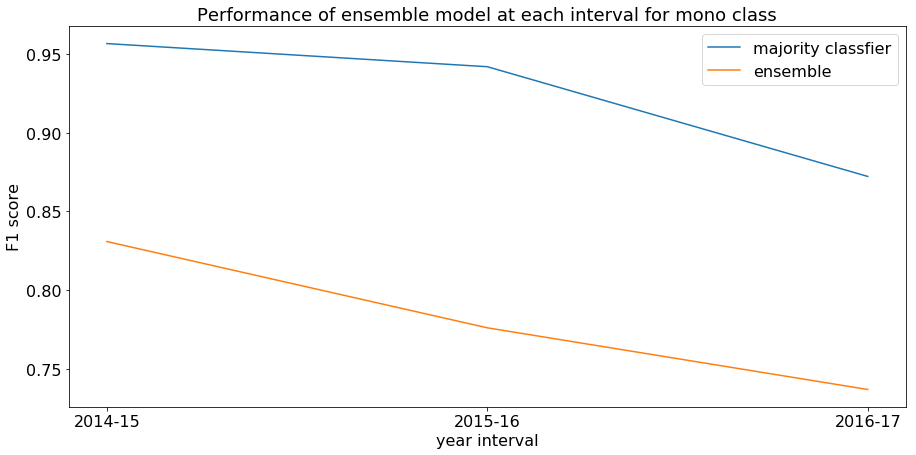

In [52]:
ensemble = [ele[0] for ele in ensemble_scores]
all_mono = [ele for ele in maj_mono]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
# plt.plot(years,maj_score_pos,label="majority classfier")
plt.plot(years,all_mono,label="majority classfier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval for mono class",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

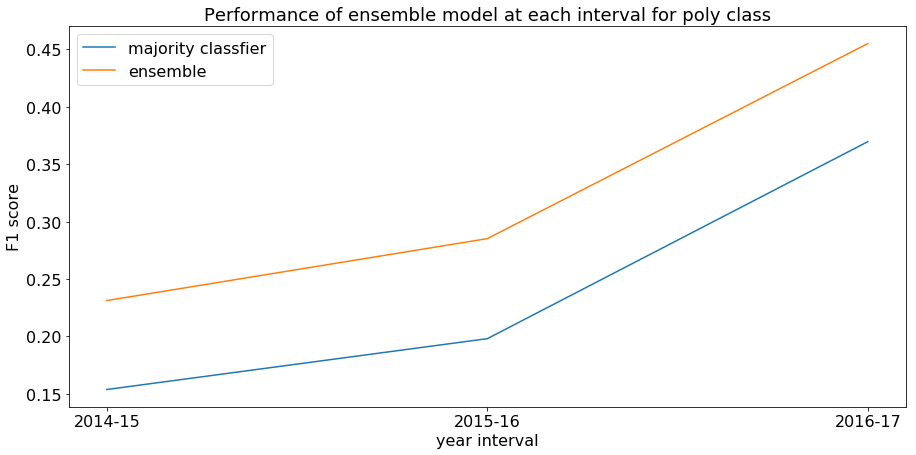

In [53]:
ensemble = [ele[1] for ele in ensemble_scores]
all_poly = [ele for ele in maj_poly]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,all_poly,label="majority classfier")
# plt.plot(years,maj_score_neg,label="majority classfier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval for poly class",fontsize=18)
plt.xlabel("year interval",fontsize=16)
plt.ylabel("F1 score",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [55]:
np.mean(ensemble) ## svm

0.3238478611797178

In [68]:
## plot the coefficients for svm
def plot_coeff_svm(model,k, feature_names):
    coef = (model.coef_.ravel())
    top_coefficients = np.argsort(coef)[-k:]
    plt.figure(figsize=(17, 8))
    plt.bar(np.arange(k), coef[top_coefficients], color="blue")
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(k), feature_names[top_coefficients], rotation=60, ha='right', fontsize=20)
    plt.show()

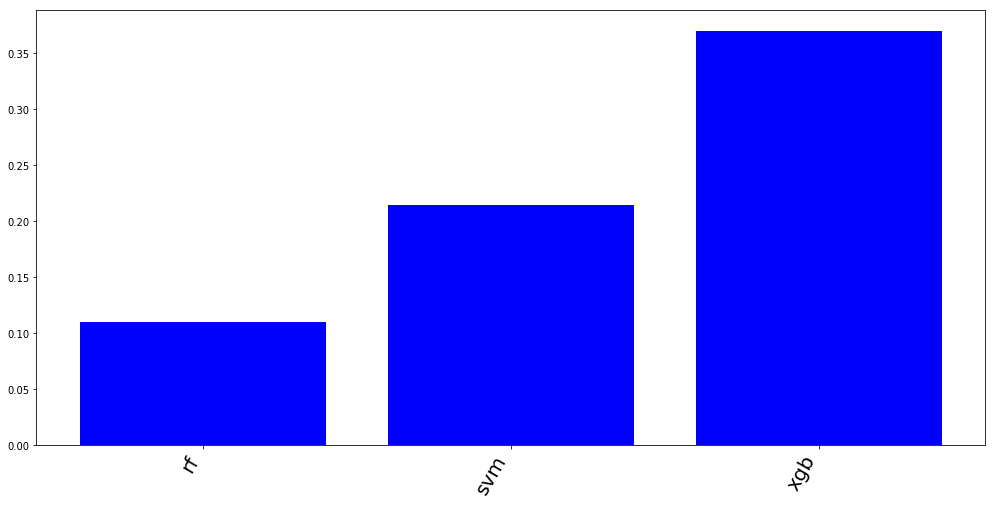

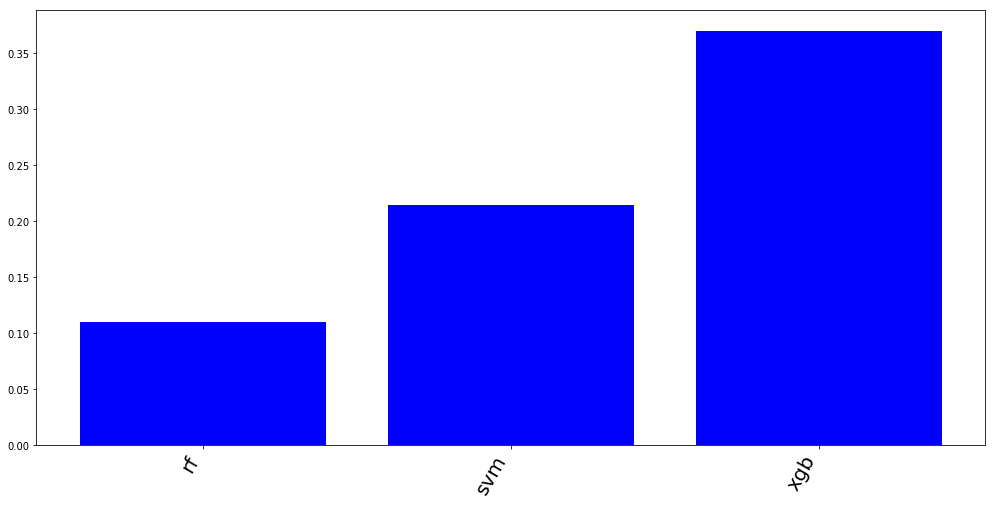

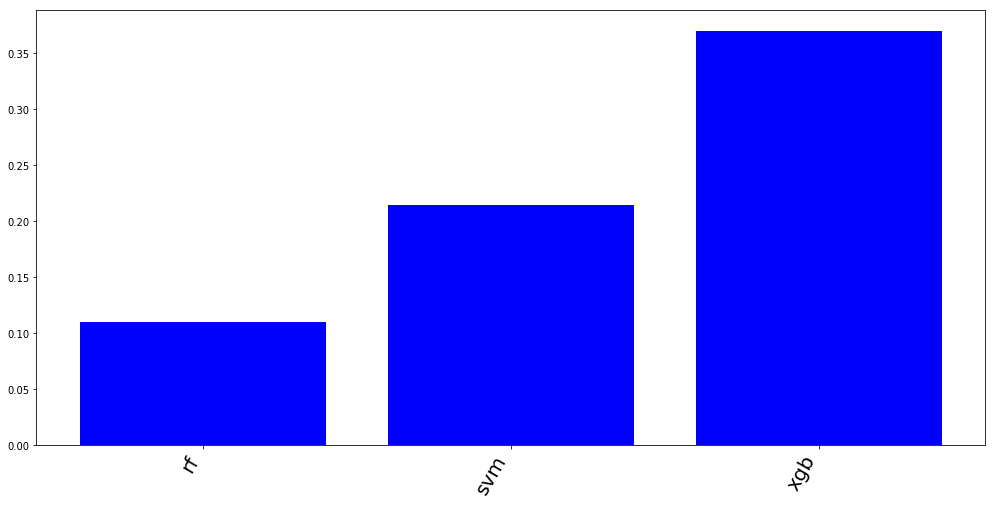

In [70]:
columns = (df_pred_final[0].loc[:,df_pred_final[0].columns != "Y"].columns)
for model in models:
    plot_coeff_svm(model,3,columns)

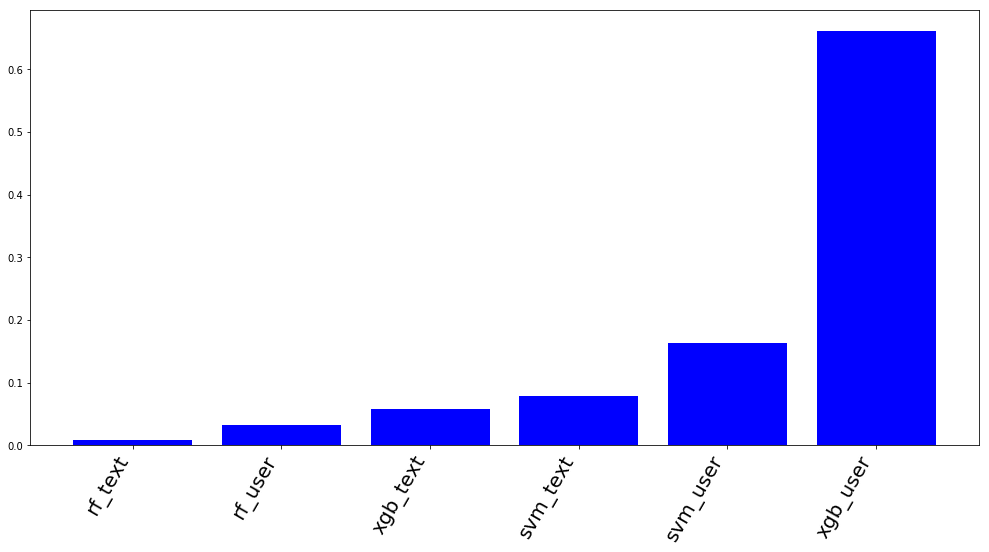

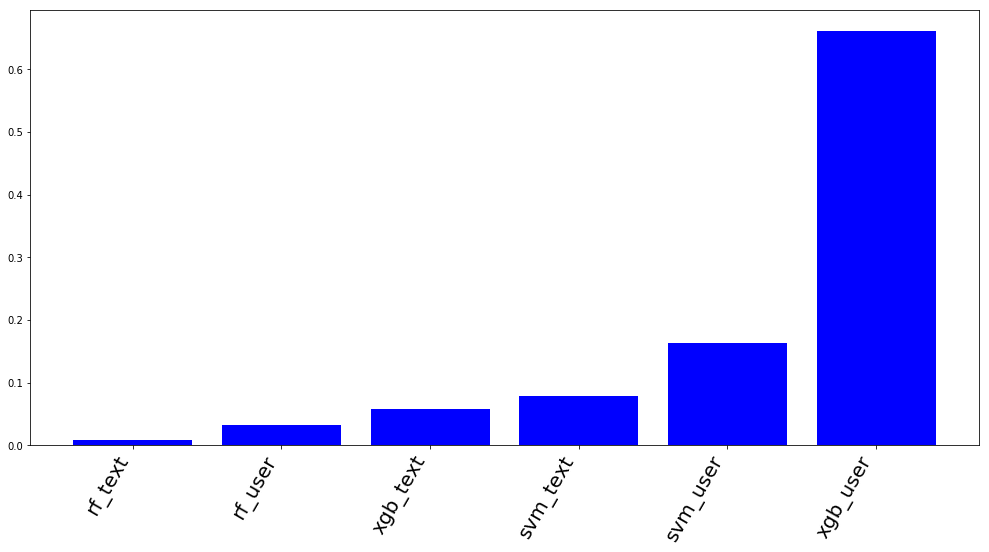

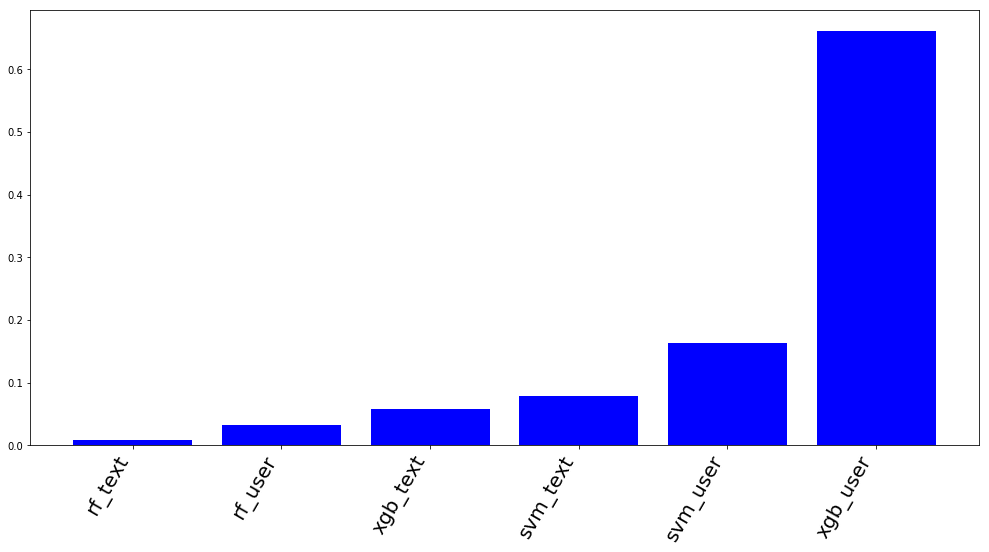

In [188]:
columns = list(df_pred_final[0].loc[:,data.columns != "Y"].columns)
for model in models:
    plot_model_coeff(model,6,columns)

In [189]:
## xgboost
print(np.mean([score[1] for score in ensemble_scores]))
ensemble_scores

0.3100967228040637


[array([0.73254069, 0.18779763]),
 array([0.72259549, 0.29198322]),
 array([0.72127178, 0.45050931])]

In [211]:
## svm
print(np.mean([score[1] for score in ensemble_scores]))
ensemble_scores

0.32109197390655075


[array([0.73682607, 0.21461218]),
 array([0.71973921, 0.29885395]),
 array([0.72257247, 0.44980979])]

In [172]:
## random forest
print(np.mean([score[1] for score in ensemble_scores]))
ensemble_scores

0.3213220349979479


[array([0.7289572 , 0.20848671]),
 array([0.71879912, 0.30425269]),
 array([0.72102573, 0.45122671])]

In [83]:
## get distribution of positives in test data..
# dump_scores
import pickle
# with open(os.path.join(model_dir,"ensemble_scores_maj.pkl"),"wb") as f:
#     pickle.dump(ensemble_scores,f)
    
with open(os.path.join(model_dir,"ensemble_scores_lstm.pkl"),"wb") as f:
    pickle.dump(ensemble_scores,f)
    
print("bufeer will not print")

bufeer will not print


## comparision plot of all models

In [232]:
## text, user , ensemble and combination

# read all scores

user_scores = pickle.load(open(os.path.join(model_dir,"user_oversample.pkl"),"rb"))
text_scores = pickle.load(open(os.path.join(model_dir,"text_oversample.pkl"),"rb"))
combinaion = pickle.load(open(os.path.join(model_dir,"user_text_oversample.pkl"),"rb"))
ensmeble_scores = pickle.load(open(os.path.join(model_dir,"ensemble_oversample_svm.pkl"),"rb"))

In [263]:
model = {"svm":[],"rf":[],"xgb":[]
        ,"lstm":[]}
ensemble_best = []
for score in ensemble_scores:
    ensemble_best.append(score[1])
#     model["lstm"].append(score["lstm"][1])

In [250]:
for name,score in model.items():
    print(name,np.mean(score))

svm 0.32403601324232206
rf 0.31174075787273864
xgb 0.30673867487579254
lstm nan


In [255]:
## user_best : svm
# text_best : rf
# combination_best : svm
# ensemble_best : ensemble

[0.2397734141996437, 0.28220597148961035, 0.45012865403771213]

In [266]:
print("ensemble",np.mean(ensemble_best))
print("combination",np.mean(combination_best))
print("text",np.mean(text_best))
print("user",np.mean(user_best))

ensemble 0.32109197390655075
combination 0.32403601324232206
text 0.2544417882872792
user 0.3190586189004605


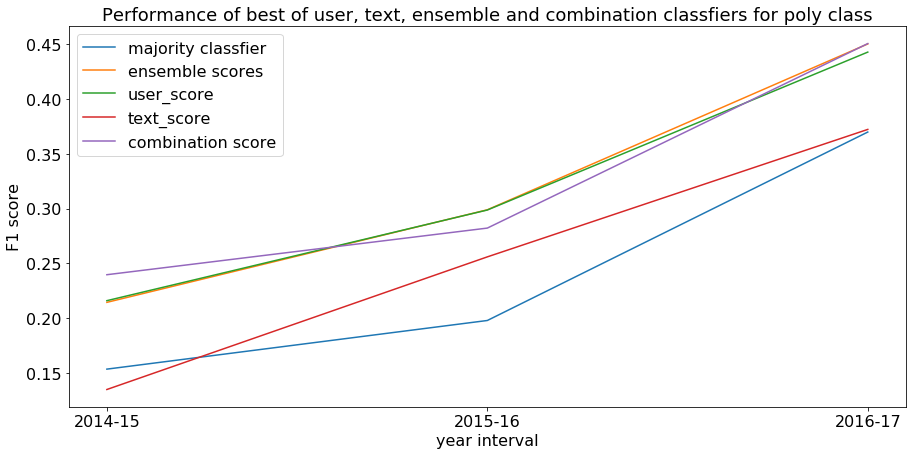

In [267]:
all_poly = [ele for ele in maj_poly]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,all_poly,label="majority classfier")
plt.plot(years,ensemble_best,label="ensemble scores")
plt.plot(years,user_best,label="user_score")
plt.plot(years,text_best,label="text_score")
plt.plot(years,combination_best,label="combination score")
plt.title("Performance of best of user, text, ensemble and combination classfiers for poly class",fontsize=18)
plt.xlabel("year interval",fontsize=16)
plt.ylabel("F1 score",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Month level

In [16]:
## sequence of tweets for user
## output prediction would be for the users so teh lstm layer would need to flatten to a single user..

## poly_turned : if users tweets weed after september (>=9 months) 
## remain_mono :
## seeing the data in different buckets:
#   1  [jan - mar )
#   2  [mar- may )
#   3  [May - july]
#   4  [July - sept]

## use lstm
## use svm
## majority
## xg boost

In [11]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [15]:
import util
import driver
import preprocessing
import lstm as lstm_module
import baselines
import pickle
import matplotlib.pyplot as plt

In [16]:
## so we are taking the users that start on Jan 2018 and change in the month of september, 
# and we change the threshold of input data to see how accurately we can predict that

In [17]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [18]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [19]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [20]:
pd.isnull(list(first_data.loc[first_data.userID == 2534]["weed_first"])[0])

True

In [21]:
## get the users who start at jan 2018 
users_2018 = list(first_data["userID"][ 
    (first_data.juul_first.dt.year == 2018)
    & (first_data.juul_first.dt.month== 1)   ## selecting 2018, Jan data
    & (((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date)) | (pd.isnull(first_data.weed_first)))
    & ((first_data.weed_first.dt.month >= 9) | (pd.isnull(first_data.weed_first)))]) # users who will change after september

poly_lbl = list(first_data["userID"].loc[(first_data.juul_first.dt.year == 2018)  
                                        & (first_data.juul_first.dt.month== 1) 
                                        & ((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date))
                                        & ((first_data.weed_first.dt.month >= 9))
                                        ])
                                            ## users that will change
print("total users", len(users_2018))
print("users will change",len(poly_lbl))


total users 10760
users will change 929


In [22]:
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018) & (juul_data.tweetCreatedAt.dt.year == 2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

## sanity check -- all users start in 2018 year..
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

total data 24018
users 10760
total data 24018
users 10760


In [23]:
## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_2018.userID.unique()
users_labelled = pd.DataFrame(users_,columns=["userID"])
users_labelled["label"] = 0  ## initialize
users_labelled.loc[users_labelled.userID.isin(poly_lbl) , "label"] = 1
len(users_labelled.loc[users_labelled.label == 1])  ## sanity check

929

In [24]:
bucket_data = []

In [25]:
bucket_data.append(preprocessing.get_month_data(data_2018,1,2))
bucket_data.append(preprocessing.get_month_data(data_2018,1,4))
bucket_data.append(preprocessing.get_month_data(data_2018,1,6))
bucket_data.append(preprocessing.get_month_data(data_2018,1,8))

length of the data 13087
total users 10760
length of the data 15477
total users 10760
length of the data 18204
total users 10760
length of the data 20383
total users 10760


## user are not changing in the month interval so using only the text features

## text features

100%|██████████| 5379/5379 [00:00<00:00, 286414.56it/s]


train-test split
final_data (10760, 1) Y 10760
at split 0
max_length 45
preparing the tokenizer
vocalb 5003
creating glove embeddign matrix
encoding the data
X-train (5379, 45)
y 9830   9830
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 45, 100)           500300    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 661,502
Trainable params: 661,502
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
         

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.93      0.73      3183
          1       0.49      0.10      0.17      2198

avg / total       0.55      0.59      0.50      5381

Train on 7372 samples, validate on 2458 samples
Epoch 1/5
7372/7372 [==============================] - 31s 4ms/step - loss: 0.8577 - acc: 0.6651 - val_loss: 1.0941 - val_acc: 0.0256
Epoch 2/5
7372/7372 [==============================] - 30s 4ms/step - loss: 0.5808 - acc: 0.6846 - val_loss: 0.9240 - val_acc: 0.2921
Epoch 3/5
7372/7372 [==============================] - 30s 4ms/step - loss: 0.5099 - acc: 0.7352 - val_loss: 0.7337 - val_acc: 0.4841
Epoch 4/5
7372/7372 [==============================] - 30s 4ms/step - loss: 0.4547 - acc: 0.7716 - val_loss: 0.7602 - val_acc: 0.4939
Epoch 5/5
7372/7372 [==============================] - 30s 4ms/step - loss: 0.4169 - acc: 0.7912 - val_loss: 0.7130 - val_acc: 0.4980


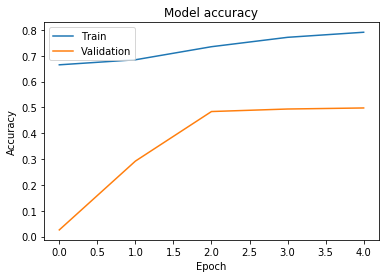

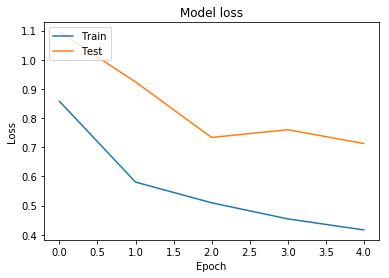

100%|██████████| 5381/5381 [00:00<00:00, 288890.24it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.95      0.93      4916
          1       0.16      0.10      0.12       465

avg / total       0.85      0.88      0.86      5381
 

at split 1
max_length 45
preparing the tokenizer
vocalb 4753
creating glove embeddign matrix


encoding the data
X-train (5381, 45)
y 9832   9832
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 45, 100)           475300    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 636,502
Trainable params: 636,502
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.53      0.93      0.68      2810
          1       0.60      0.11      0.1

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.93      0.74      3247
          1       0.50      0.11      0.18      2132

avg / total       0.57      0.60      0.52      5379

Train on 7374 samples, validate on 2458 samples
Epoch 1/5
7374/7374 [==============================] - 31s 4ms/step - loss: 0.8582 - acc: 0.6635 - val_loss: 1.0144 - val_acc: 0.0028
Epoch 2/5
7374/7374 [==============================] - 29s 4ms/step - loss: 0.5812 - acc: 0.6880 - val_loss: 1.0067 - val_acc: 0.2958
Epoch 3/5
7374/7374 [==============================] - 29s 4ms/step - loss: 0.5091 - acc: 0.7384 - val_loss: 0.6588 - val_acc: 0.5232
Epoch 4/5
7374/7374 [==============================] - 30s 4ms/step - loss: 0.4582 - acc: 0.7669 - val_loss: 0.5787 - val_acc: 0.5627
Epoch 5/5
7374/7374 [==============================] - 29s 4ms/step - loss: 0.4213 - acc: 0.7840 - val_loss: 0.6203 - val_acc: 0.4996


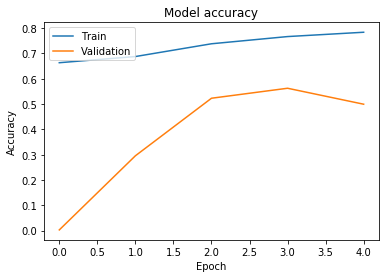

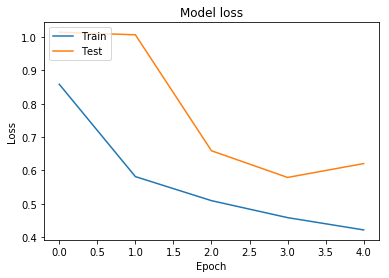

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.93      0.92      4915
          1       0.16      0.14      0.15       464

avg / total       0.85      0.86      0.86      5379
 

svm [0.67112372 0.18383357]
rf [0.72719408 0.16427194]
xgb [0.73277486 0.17384005]
lstm [0.92921672 0.13601938]


100%|██████████| 5379/5379 [00:00<00:00, 278759.99it/s]


train-test split
final_data (10760, 1) Y 10760
at split 0
max_length 53
preparing the tokenizer
vocalb 5486
creating glove embeddign matrix
encoding the data
X-train (5379, 53)
y 9830   9830
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 53)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 53, 100)           548600    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 709,802
Trainable params: 709,802
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
         

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.78      0.92      0.85      4176
          1       0.31      0.12      0.17      1205

avg / total       0.68      0.74      0.70      5381

Train on 7372 samples, validate on 2458 samples
Epoch 1/5
7372/7372 [==============================] - 36s 5ms/step - loss: 0.8491 - acc: 0.6689 - val_loss: 0.9389 - val_acc: 0.1139
Epoch 2/5
7372/7372 [==============================] - 34s 5ms/step - loss: 0.5642 - acc: 0.7060 - val_loss: 0.9863 - val_acc: 0.3804
Epoch 3/5
7372/7372 [==============================] - 34s 5ms/step - loss: 0.4995 - acc: 0.7509 - val_loss: 0.7602 - val_acc: 0.5321
Epoch 4/5
7372/7372 [==============================] - 34s 5ms/step - loss: 0.4406 - acc: 0.7828 - val_loss: 0.4828 - val_acc: 0.6778
Epoch 5/5
7372/7372 [==============================] - 34s 5ms/step - loss: 0.3990 - acc: 0.8071 - val_loss: 0.6488 - val_acc: 0.6058


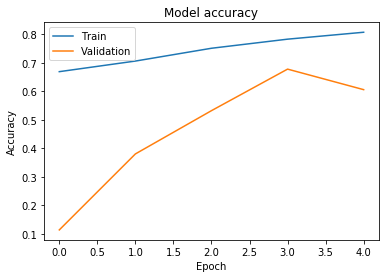

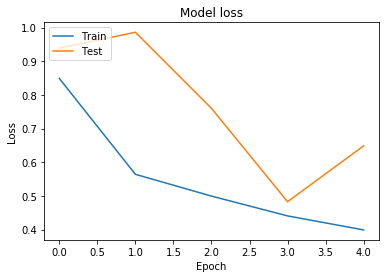

100%|██████████| 5381/5381 [00:00<00:00, 277437.61it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.91      0.91      4916
          1       0.14      0.16      0.15       465

avg / total       0.85      0.84      0.85      5381
 

at split 1
max_length 52
preparing the tokenizer
vocalb 5284
creating glove embeddign matrix


encoding the data
X-train (5381, 52)
y 9832   9832
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 52)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 52, 100)           528400    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 689,602
Trainable params: 689,602
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.93      0.69      2888
          1       0.59      0.11      0.1

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.93      0.76      3440
          1       0.45      0.11      0.17      1939

avg / total       0.57      0.63      0.55      5379

Train on 7374 samples, validate on 2458 samples
Epoch 1/5
7374/7374 [==============================] - 35s 5ms/step - loss: 0.8525 - acc: 0.6691 - val_loss: 1.0941 - val_acc: 0.1204
Epoch 2/5
7374/7374 [==============================] - 33s 5ms/step - loss: 0.5821 - acc: 0.6953 - val_loss: 0.8605 - val_acc: 0.3739
Epoch 3/5
7374/7374 [==============================] - 33s 4ms/step - loss: 0.5056 - acc: 0.7524 - val_loss: 0.7928 - val_acc: 0.5114
Epoch 4/5
7374/7374 [==============================] - 33s 5ms/step - loss: 0.4541 - acc: 0.7754 - val_loss: 0.6305 - val_acc: 0.5781
Epoch 5/5
7374/7374 [==============================] - 33s 4ms/step - loss: 0.4005 - acc: 0.8053 - val_loss: 0.6188 - val_acc: 0.5822


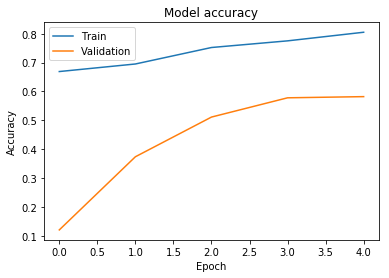

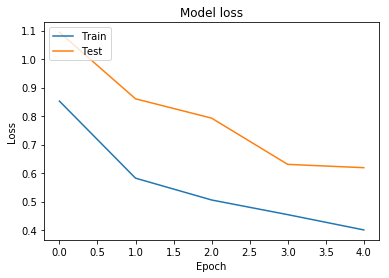

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.92      0.92      4915
          1       0.17      0.18      0.17       464

avg / total       0.86      0.85      0.86      5379
 

svm [0.73548507 0.18223714]
rf [0.82164968 0.1833971 ]
xgb [0.80507859 0.17296867]
lstm [0.91699944 0.1629759 ]


100%|██████████| 5379/5379 [00:00<00:00, 278446.91it/s]


train-test split
final_data (10760, 1) Y 10760
at split 0
max_length 60
preparing the tokenizer
vocalb 6040
creating glove embeddign matrix
encoding the data
X-train (5379, 60)
y 9830   9830
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 60, 100)           604000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 765,202
Trainable params: 765,202
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
         

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.78      0.93      0.85      4097
          1       0.38      0.14      0.20      1284

avg / total       0.68      0.74      0.69      5381

Train on 7372 samples, validate on 2458 samples
Epoch 1/5
7372/7372 [==============================] - 40s 5ms/step - loss: 0.8433 - acc: 0.6795 - val_loss: 1.2022 - val_acc: 0.1542
Epoch 2/5
7372/7372 [==============================] - 36s 5ms/step - loss: 0.5582 - acc: 0.7135 - val_loss: 0.7752 - val_acc: 0.5163
Epoch 3/5
7372/7372 [==============================] - 36s 5ms/step - loss: 0.4937 - acc: 0.7565 - val_loss: 0.7972 - val_acc: 0.5391
Epoch 4/5
7372/7372 [==============================] - 36s 5ms/step - loss: 0.4367 - acc: 0.7971 - val_loss: 0.6820 - val_acc: 0.5716
Epoch 5/5
7372/7372 [==============================] - 37s 5ms/step - loss: 0.3930 - acc: 0.8116 - val_loss: 0.5683 - val_acc: 0.6424


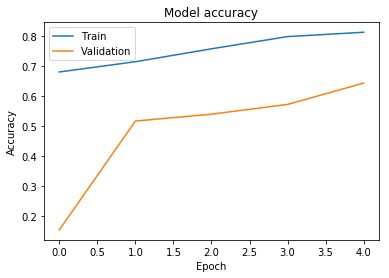

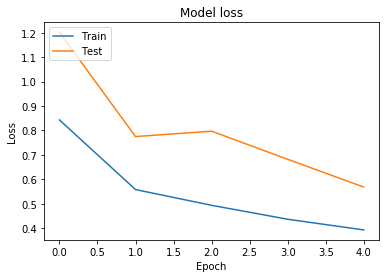

100%|██████████| 5381/5381 [00:00<00:00, 252625.36it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.91      0.92      4916
          1       0.16      0.18      0.17       465

avg / total       0.86      0.85      0.85      5381
 

at split 1
max_length 60
preparing the tokenizer
vocalb 5835
creating glove embeddign matrix


encoding the data
X-train (5381, 60)
y 9832   9832
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 60, 100)           583500    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 744,702
Trainable params: 744,702
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.94      0.69      2892
          1       0.60      0.11      0.1

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.92      0.87      4372
          1       0.28      0.13      0.18      1007

avg / total       0.72      0.77      0.74      5379

Train on 7374 samples, validate on 2458 samples
Epoch 1/5
7374/7374 [==============================] - 41s 6ms/step - loss: 0.8442 - acc: 0.6758 - val_loss: 0.9476 - val_acc: 0.2217
Epoch 2/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.5647 - acc: 0.7091 - val_loss: 0.7992 - val_acc: 0.4479
Epoch 3/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.4950 - acc: 0.7544 - val_loss: 0.6314 - val_acc: 0.5598
Epoch 4/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.4339 - acc: 0.7929 - val_loss: 0.5993 - val_acc: 0.5777
Epoch 5/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.3894 - acc: 0.8186 - val_loss: 0.5708 - val_acc: 0.5899


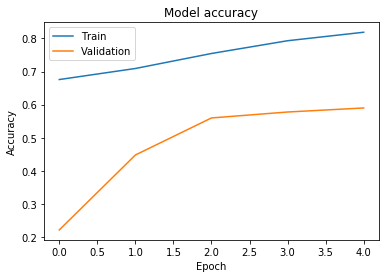

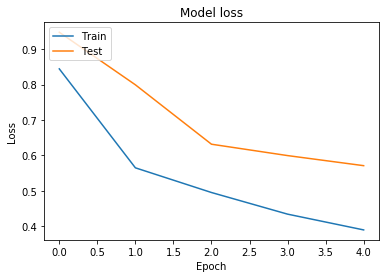

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.93      0.93      4915
          1       0.19      0.16      0.18       464

avg / total       0.86      0.87      0.86      5379
 

svm [0.75316374 0.19992795]
rf [0.80794333 0.20095253]
xgb [0.85741639 0.18946789]
lstm [0.92152423 0.1712963 ]


100%|██████████| 5379/5379 [00:00<00:00, 229371.00it/s]


train-test split
final_data (10760, 1) Y 10760
at split 0
max_length 60
preparing the tokenizer
vocalb 6490
creating glove embeddign matrix
encoding the data
X-train (5379, 60)
y 9830   9830
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 60, 100)           649000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 402       
Total params: 810,202
Trainable params: 810,202
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
         

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.93      0.87      4318
          1       0.35      0.15      0.21      1063

avg / total       0.73      0.78      0.74      5381

Train on 7372 samples, validate on 2458 samples
Epoch 1/5
7372/7372 [==============================] - 41s 6ms/step - loss: 0.8425 - acc: 0.6786 - val_loss: 1.1615 - val_acc: 0.1151
Epoch 2/5
7372/7372 [==============================] - 38s 5ms/step - loss: 0.5577 - acc: 0.7103 - val_loss: 0.9244 - val_acc: 0.4089
Epoch 3/5
7372/7372 [==============================] - 38s 5ms/step - loss: 0.4895 - acc: 0.7617 - val_loss: 0.7770 - val_acc: 0.5549
Epoch 4/5
7372/7372 [==============================] - 38s 5ms/step - loss: 0.4299 - acc: 0.7957 - val_loss: 0.5889 - val_acc: 0.6424
Epoch 5/5
7372/7372 [==============================] - 38s 5ms/step - loss: 0.3925 - acc: 0.8180 - val_loss: 0.4979 - val_acc: 0.6896


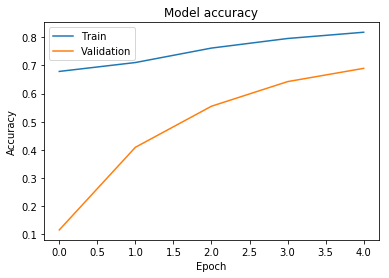

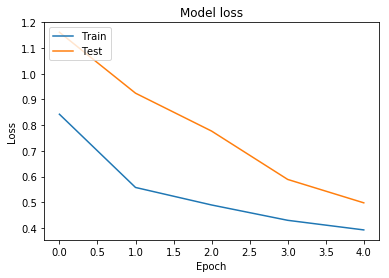

100%|██████████| 5381/5381 [00:00<00:00, 239612.17it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.91      0.91      4916
          1       0.16      0.18      0.17       465

avg / total       0.86      0.84      0.85      5381
 

at split 1
max_length 60
preparing the tokenizer
vocalb 6363
creating glove embeddign matrix


encoding the data
X-train (5381, 60)
y 9832   9832
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 60, 100)           636300    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 402       
Total params: 797,502
Trainable params: 797,502
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.73      0.94      0.82      3823
          1       0.49      0.15      0.2

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.83      0.93      0.88      4360
          1       0.35      0.16      0.22      1019

avg / total       0.74      0.78      0.75      5379

Train on 7374 samples, validate on 2458 samples
Epoch 1/5
7374/7374 [==============================] - 41s 6ms/step - loss: 0.8420 - acc: 0.6804 - val_loss: 0.8771 - val_acc: 0.3299
Epoch 2/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.5640 - acc: 0.7099 - val_loss: 0.9501 - val_acc: 0.3942
Epoch 3/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.4902 - acc: 0.7602 - val_loss: 0.6753 - val_acc: 0.5773
Epoch 4/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.4252 - acc: 0.7992 - val_loss: 0.6242 - val_acc: 0.5985
Epoch 5/5
7374/7374 [==============================] - 38s 5ms/step - loss: 0.3750 - acc: 0.8229 - val_loss: 0.5557 - val_acc: 0.6412


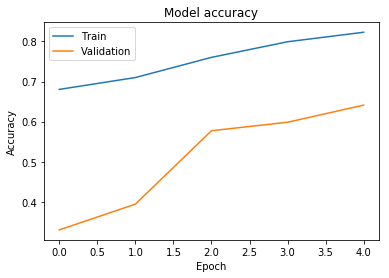

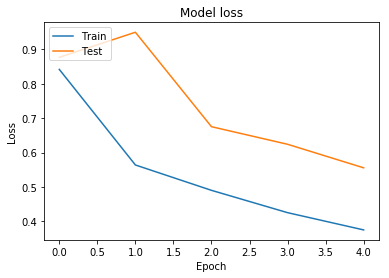

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.93      0.93      0.93      4915
          1       0.21      0.21      0.21       464

avg / total       0.86      0.86      0.86      5379
 

svm [0.82631309 0.2220018 ]
rf [0.78670438 0.20438549]
xgb [0.87254296 0.21656787]
lstm [0.91968687 0.19067501]


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 2
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
for data in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
        
    ## combining all of user and text data
    final_data = pd.DataFrame()
    final_data["Text"] = pd.DataFrame(total_data["tweetText"])
    print("final_data",final_data.shape,"Y",len(Y))
    
    
    fold_scores = {"svm":[],"rf":[],"xgb":[],"lstm":[]}
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y)):
        print("at split",split)
        Y_test =  Y[test_ind]
        Y_train = Y[train_ind]
        
        test_data = final_data.iloc[test_ind]
        train_data = final_data.iloc[train_ind]
        
        ## preparing train,test lstm
        X_train_lstm,keras_tkzr,max_len,vocalb_size,embedding_matrix = lstm_module.prepare_lstm_data(train_data["Text"],dimension)
        X_test_lstm = lstm_module.get_encoded_data(test_data["Text"],keras_tkzr,max_len)
        
        ## preparing train,test tf_idf svd
        X_train_svd,tf_idf, svd = baselines.encode_text_svd(train_data["Text"])
        X_test_svd = baselines.get_encoded_text_svd(test_data["Text"], tf_idf, svd)
        
        ## oversample the train data
        X_train_svd, Y_train_ = util.get_oversample(X_train_svd,Y_train)
        X_train_lstm, Y_train = util.get_oversample(X_train_lstm,Y_train)
        
        print("y",len(Y_train)," ",len(Y_train_))
        
        ## preparing the models
        models = baselines.get_baseline_models()
        lstm_model = lstm_module.create_model(max_len,vocalb_size,100,embedding_matrix)
        for name,model in models.items(): 
            model.fit(X_train_svd,Y_train)
            y_pred = model.predict(X_test_svd)
            print(name,"user Classification report \n",classification_report(y_pred,Y_test))
            score = (precision_recall_fscore_support(y_pred, Y_test, average=None)[2])
            fold_scores[name].append(score)
        
        ## getting lstm prediction
        history = lstm_model.fit(X_train_lstm,Y_train,validation_split=0.25, nb_epoch=epoch,verbose=1, batch_size=32)
        lstm_module.training_plot(history) ## plotting the training history lstm
        lstm_pred_ = lstm_model.predict(X_test_lstm)
        lstm_pred = [np.argmax(value) for value in lstm_pred_]  ## sigmoid
        print('  Classification Report lstm:\n', classification_report(Y_test, lstm_pred), '\n')
        score = (precision_recall_fscore_support(Y_test, lstm_pred, average=None)[2])
        fold_scores["lstm"].append(score)
    
    for name,scores in fold_scores.items():
        score1 = np.mean([ele[0] for ele in scores])
        score2 = np.mean([ele[1] for ele in scores])
        fold_scores[name] = np.array([score1,score2])
        print(name,fold_scores[name])
    final_scores.append(fold_scores)
    Y_tests.append(Y_test)

In [29]:
# dump_scores
import pickle

with open(os.path.join(model_dir,"month_scores.pkl"),"wb") as f:
    pickle.dump(final_scores,f)

In [30]:
1 + 1

2

## plotting

In [444]:
scores = pickle.load(open(os.path.join(model_dir,"text_over_month_scores.pkl"),"rb"))

In [ ]:
scores["lstm"]

In [ ]:
for score in scores["lstm"]:
    print(np.mean(score))

In [31]:
from sklearn.metrics import precision_recall_fscore_support
maj_mono = []
maj_poly = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos)[2][1]
    maj_poly.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg)[2][0]
    maj_mono.append(maj_neg)

length of Y_test 5379
positives in Y_test 464
length of Y_test 5379
positives in Y_test 464
length of Y_test 5379
positives in Y_test 464
length of Y_test 5379
positives in Y_test 464


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


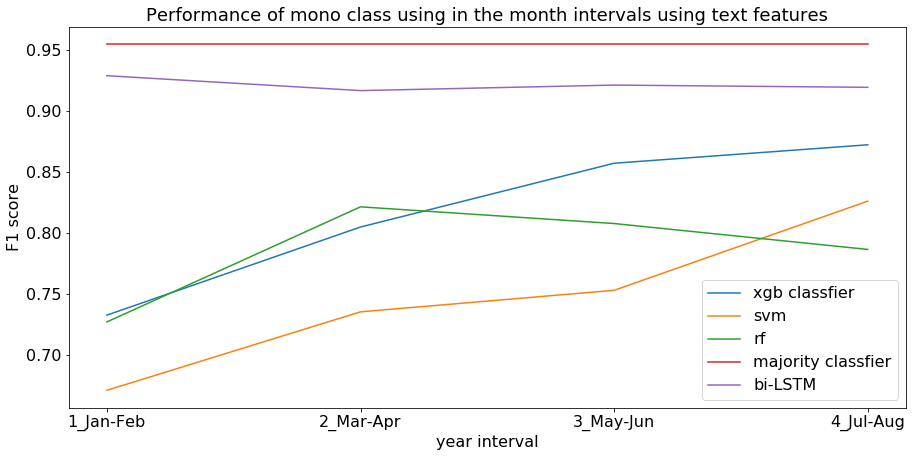

In [32]:
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores = []
all_mono = [score for score in maj_mono]
for scores in final_scores:
    svm_scores.append(scores["svm"][0])
    rf_scores.append(scores["rf"][0])
    xgb_scores.append(scores["xgb"][0])
    lstm_scores.append(scores["lstm"][0])
## plotting user features
plt.figure(figsize=(15,7))
months = ["1_Jan-Feb","2_Mar-Apr","3_May-Jun","4_Jul-Aug"]
plt.plot(months,xgb_scores,label="xgb classfier")
plt.plot(months,svm_scores,label="svm")
plt.plot(months,rf_scores,label="rf")
plt.plot(months,all_mono,label="majority classfier")
plt.plot(months,lstm_scores,label="bi-LSTM")
plt.title("Performance of mono class using in the month intervals using text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

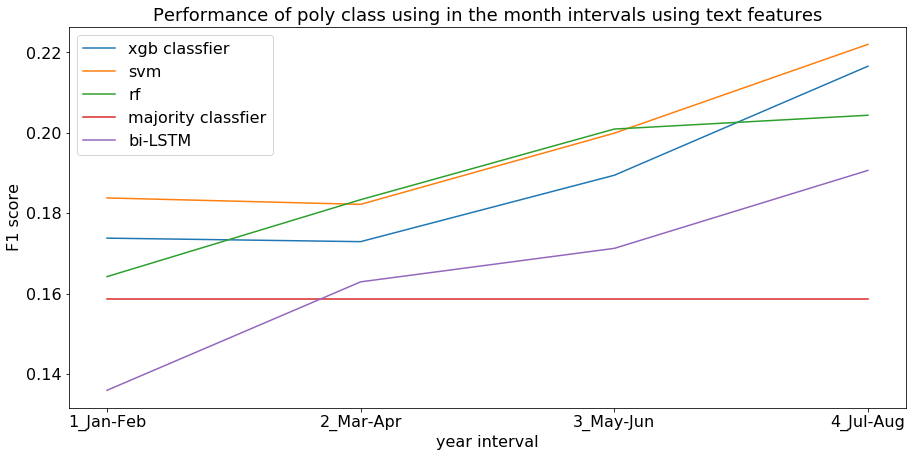

In [36]:
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores = []
all_poly = [score for score in maj_poly]
for scores in final_scores:
    svm_scores.append(scores["svm"][1])
    rf_scores.append(scores["rf"][1])
    xgb_scores.append(scores["xgb"][1])
    lstm_scores.append(scores["lstm"][1])
## plotting user features
plt.figure(figsize=(15,7))
months = ["1_Jan-Feb","2_Mar-Apr","3_May-Jun","4_Jul-Aug"]
plt.plot(months,xgb_scores,label="xgb classfier")
plt.plot(months,svm_scores,label="svm")
plt.plot(months,rf_scores,label="rf")
plt.plot(months,all_poly,label="majority classfier")
plt.plot(months,lstm_scores,label="bi-LSTM")
plt.title("Performance of poly class using in the month intervals using text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [39]:
print("svm",svm_scores, np.mean(svm_scores))
print("rf",rf_scores, np.mean(rf_scores))
print("xgb",xgb_scores, np.mean(xgb_scores))
print("lstm",lstm_scores, np.mean(lstm_scores))

svm [0.18383356639092638, 0.18223714055130008, 0.19992795353528914, 0.2220017964040767] 0.19700011422039806
rf [0.16427194479539647, 0.1833971007720241, 0.20095252886058915, 0.20438549176956328] 0.18825176654939324
xgb [0.17384005087118054, 0.1729686694027675, 0.18946788667040582, 0.2165678739501435] 0.18821112022362435
lstm [0.13601938393279267, 0.16297590348650745, 0.1712962962962963, 0.1906750099853548] 0.1652416484252378


In [40]:
np.mean(all_poly)

0.15882252267670718

In [ ]:
for svm,tf_idf,month in zip(svm_models,tfidf_list,months):
    print(month)
    plot_coeff(20,svm,tf_idf.get_feature_names())

In [229]:
## might need to use it
dr = (cleaned_data_list)[3]
dr.loc[dr["tweetText"].apply(get_length) > 70]

,userID,tweetText,label
2,22363298,"i don't exactly know what a JUUL is but it's probably what ur man is putting around my neck ??????;crying in bed bc my cheating husband is brain dead and can't JUUL all over my tiddies anymore 😞; ok but is this what everyone talks about when they say JUUL? i don't know what it is; omg i just expanded the video and saw that u cited the fact that it's JUUL in the text...sorry to ask that redundant clarification before 😞;in the middle of working one of the single worst bar shifts i have ever worked last night, at one point i went to the backyard to hunt down someone who dipped on their tab and some random girl walks up and shoves a charger in my hand and says “CHARGE MY JUUL THXX” my goooooddddd; my ass is a temple i would not sully with a fucking JUUL",1
9,36601913,We will all get punished for juul i just don’t know how or when;I guess the bright side is the juul is very very clean now ... ya we washed our juul;Sometimes ... every so often ... you may find yourself blessed with a miracle when you don’t deserve one. Thing is ... we all need to remember that the universe may be cruel but is also serendipitously merciful. We found the juul.;My mom cleaned my apt but also slurped up all my juul juice.... trade offs,1
10,40020666,"I saw a dude charging a Juul using a Wii's USB port so that's how my Genesis is going;its weird mango chose his tag after that juul pod;I got drunk and bought a Juul last night so that's where I'm at in life;can I get juul to sponsor me for melee;shout out to this kid wearing a ""buchholz high school class of 2019"" shirt at this coffee shop ripping a juul as he counts quarters to buy a small coffee;Tbh I should just run up and steal this kid's juul. Like who is he gonna tattle to?;I know I talk a lot about the first juul rip of the day and how I like the crackle but goddamn it starts the day off right;i bought bootleg juul pods at a store next to my brunch and they're fuego;Just ripped the fattest Juul rip walking past an ABC7 camera so watch for that later",0
32,84390643,"I don’t do Juul. I have Jesus. ;The green light from the great gatsby was from a juul;disrespect is putting chapstick on and then hitting someone else’s juul right after;Yeah sex is cool and all, but have you ever ripped a Juul first thing in the morning?;ur mcm missed the birth of his first child because he was buying juul pods at the gas station across the street;When you rip the juul and hear mama comin down the hall...lmao ;Please bro lemme hit your juul bro please bro just one hit bro cmon bro lemme take a fat rip off your juul bro please bro I need your juul bro please lemme hit that juul bro please just one hit bro please bro I gottta have my juul fix bro please just one hit please bro juul me;what if the green light that gatsby saw across the water was daisy hitting her juul;Overheard in the quad, “yeah man, I almost forget I have a juul when I’m around her.” Ladies and gentlemen, chivalry is far from dead.;I was your juul but you ran out of pods - Rupi Kaur;saw this rando hitting his juul and the bond was made. bringing america together one cloud at a time ;WHY DID MY PARENTS LET ME ON THE INTERNET ALONE WHEN I WAS 8!!!!!! they broke me i didn't have to be like this.. i could be using a juul and listening to post malone with all the locals right now.... this life i live is just so messed up;Is 3 (three) juul hits a valid meal replacement yes or no;them: “you need to have more fruit” me: *gets mango juul pods instead of mint* “that should do it”;the green light from great gatsby was from a juul;The green light from Gatsby was just Daisy’s juul;this dude just hit a weed vape and a juul at the same time and called it a “silicon valley spliff” oh my god;*at thanksgiving dinner Mom: so your bf is a professional jeweler, that’s so interesting Daughter: no he’s a professional juuler Me: rips juul, blows out smoke to form the word “nice”;Today's list: ✅wake up rip juul ✅lip sync to Drake's new album a

## End